In [1]:
from __future__ import division
from collections import Counter, OrderedDict
from gensim.models import KeyedVectors, FastText
from gensim.models.coherencemodel import CoherenceModel
import gensim
from pprint import pprint
from sklearn.decomposition import NMF, LatentDirichletAllocation
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report, precision_recall_fscore_support, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.svm import LinearSVC
import copy
import itertools
import math
import numpy as np
import pandas as pd
import pickle
import scipy
import string
import time

In [2]:
#%config IPCompleter.greedy=True  # autocompletion

In [2]:
data_path = '../../data/'
path_to_ahn_recipes_with_cuisines = data_path + 'ahn_flavour_network/srep00196-s3.csv'

# Recipe ingredient lists with cuisines

## load dataset and print statistics about it

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # 'all'

In [5]:
%matplotlib qt
#%matplotlib inline

In [3]:
with open(path_to_ahn_recipes_with_cuisines, 'r') as f:
    ing_list2cuisine = np.asarray([(l.strip().split(',')[1::], l.split(',')[0]) for l in f.readlines()[4::]])
inglist2cuisine = ing_list2cuisine
flat_inglists_with_cuisine = [(inglist_tuple[0]).append(inglist_tuple[1] + 'CUISINE') or inglist_tuple[0] for inglist_tuple in ing_list2cuisine]


cuisine2id = {'NorthAmerican': 0,
               'WesternEuropean': 1,
               'NorthernEuropean': 2,
               'EasternEuropean': 3,
               'EastAsian': 4,
               'SoutheastAsian': 5,
               'SouthAsian': 6,
               'African': 7,
               'LatinAmerican': 8,
               'MiddleEastern': 9,
               'SouthernEuropean': 10}

id2cuisine = {v: k for k, v in cuisine2id.items()}

cuisine_labels = [cuisine for cuisine in cuisine2id.keys()]

In [4]:
cuisine_labels

['NorthAmerican',
 'WesternEuropean',
 'NorthernEuropean',
 'EasternEuropean',
 'EastAsian',
 'SoutheastAsian',
 'SouthAsian',
 'African',
 'LatinAmerican',
 'MiddleEastern',
 'SouthernEuropean']

In [5]:
def merge_cuisines(ing_list2cuisine):  # deClerq 19
    western = [['EasternEuropean', 'NorthernEuropean', 'WesternEuropean', 'NorthAmerican'], 'Western']
    eastern = [['EastAsian', 'SoutheastAsian'], 'Eastern']
    south_asian = [['SouthAsian'], 'SouthAsian']
    southern = [['African', 'LatinAmerican', 'MiddleEastern', 'SouthernEuropean'], 'Southern']

    merged_cuisine_ing_list2cuisine = ing_list2cuisine.copy()
    for ing_list in merged_cuisine_ing_list2cuisine:
        if ing_list[1] in western[0]:
            ing_list[1] = western[1]
        elif ing_list[1] in eastern[0]:
            ing_list[1] = eastern[1]
        elif ing_list[1] in south_asian[0]:
            ing_list[1] = south_asian[1]
        elif ing_list[1] in southern[0]:
            ing_list[1] = southern[1]
    return merged_cuisine_ing_list2cuisine

merged_ing_list2cuisine =  merge_cuisines(ing_list2cuisine)

# Topic Modeling and TFIDF Exploration

## TFIDF Exploration

In [6]:
#tfidf_exploration_ing_lists = [ing_list[0] for ing_list in ing_list2cuisine if ing_list[1]=='African']
tfidf_exploration_ing_lists = [ing_list[0] for ing_list in ing_list2cuisine]
print(tfidf_exploration_ing_lists[:3])

[['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger', 'AfricanCUISINE'], ['cane_molasses', 'ginger', 'cumin', 'garlic', 'tamarind', 'bread', 'coriander', 'vinegar', 'onion', 'beef', 'cayenne', 'parsley', 'wheat_bread', 'yogurt', 'vegetable_oil', 'egg', 'AfricanCUISINE'], ['butter', 'pepper', 'onion', 'cardamom', 'cayenne', 'ginger', 'cottage_cheese', 'garlic', 'brassica', 'AfricanCUISINE']]


In [7]:
tfidf_vectorizer = TfidfVectorizer(preprocessor=lambda x: x, 
                                   tokenizer=lambda x: x, 
                                   norm='l1', 
                                   use_idf=True)  # already preprc+tknzd

ing_lists2tfidf_vec = tfidf_vectorizer.fit_transform(tfidf_exploration_ing_lists)

tfidf_index2ing = {i[1]: i[0] for i in tfidf_vectorizer.vocabulary_.items()}

tfidf_feature_names = tfidf_vectorizer.get_feature_names()


In [8]:
#%%capture cap --no-stderr
ing2tfidf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))
most_common_ings = pd.DataFrame(sorted(ing2tfidf.items(), key=lambda x: x[1]))
least_common_ings = pd.DataFrame(sorted(ing2tfidf.items(), key=lambda x: x[1], reverse=True))

print('The most common ingredients in the ing_lists2cuisines are: ')
pprint(most_common_ings[:50])
print('')
print('The least common ingredients in the ing_lists2cuisines are: ')
pprint(least_common_ings[:50])

The most common ingredients in the ing_lists2cuisines are: 
                          0         1
0      NorthAmericanCUISINE  1.307927
1                       egg  1.991989
2                     wheat  2.000088
3                    butter  2.001918
4                     onion  2.142075
5                    garlic  2.207264
6                      milk  2.477306
7             vegetable_oil  2.658387
8                     cream  2.716454
9                    tomato  2.740679
10                olive_oil  2.747259
11             black_pepper  2.756648
12                   pepper  2.830243
13                  vanilla  2.834114
14                  cayenne  2.960925
15                  vinegar  2.993522
16            cane_molasses  2.998733
17              bell_pepper  3.268123
18                 cinnamon  3.310742
19                  parsley  3.318085
20                  chicken  3.367460
21              lemon_juice  3.418008
22                     beef  3.460827
23                    cocoa 

In [14]:
#with open('tfidf-exloration.txt', 'w') as handle:
#    handle.write(cap.stdout)

In [821]:
#with open("tfidf-exloration_mostcommonwords.tex", "w") as exloration_mostcommonwords:
#    exloration_mostcommonwords.write(str(most_common_ings.to_latex()))
#with open("tfidf-exloration_leastcommonwords.tex", "w") as exloration_leastcommonwords:
#    exloration_leastcommonwords.write(str(least_common_ings.to_latex()))

18675

18675

In [98]:
df = pd.DataFrame([('African', 352),
('EastAsian', 2512),
('EasternEuropean', 381),
('LatinAmerican', 2917),
('MiddleEastern', 645),
('NorthAmerican', 41524),
('NorthernEuropean', 250),
('SouthAsian', 621),
('SoutheastAsian', 457),
('SouthernEuropean', 4180),
('WesternEuropean', 2659)]).rename(index=str, columns={0: "Cuisine label", 1: "Number of ingredient lists"})

df.index = range(1,len(df)+1)
df 
with open('cuisines-occurrences.tex', 'w') as handle:
    handle.write(str(df.to_latex()))

,Cuisine label,Number of ingredient lists
1,African,352
2,EastAsian,2512
3,EasternEuropean,381
4,LatinAmerican,2917
5,MiddleEastern,645
6,NorthAmerican,41524
7,NorthernEuropean,250
8,SouthAsian,621
9,SoutheastAsian,457
10,SouthernEuropean,4180


737

In [100]:
df = pd.DataFrame([('Eastern', 2969, ('EastAsian', 'SoutheastAsian')),
('SouthAsian', 621, ('SouthAsian')),
('Southern', 8094, ('African', 'LatinAmerican', 'MiddleEastern', 'SouthernEuropean')),
('Western', 44814, ('EasternEuropean', 'NorthernEuropean', 'WesternEuropean', 'NorthAmerican'))])

df.index = range(1,len(df)+1)
df 
#with open('cuisines-occurrences-merged.tex', 'w') as handle:
#    handle.write(str(df.to_latex()))

,0,1,2
1,Eastern,2969,"(EastAsian, SoutheastAsian)"
2,SouthAsian,621,SouthAsian
3,Southern,8094,"(African, LatinAmerican, MiddleEastern, Southe..."
4,Western,44814,"(EasternEuropean, NorthernEuropean, WesternEur..."


# LDA Pipeline

In [168]:
print(flat_inglists_with_cuisine[:3])
inglist2cuisine_corpus_dict = {'doc' + str(index+1): ', '.join(map(str, item))  for index, item in enumerate(flat_inglists_with_cuisine)}
#inglist2cuisine_corpus_dict

[['chicken', 'cinnamon', 'soy_sauce', 'onion', 'ginger', 'AfricanCUISINE'], ['cane_molasses', 'ginger', 'cumin', 'garlic', 'tamarind', 'bread', 'coriander', 'vinegar', 'onion', 'beef', 'cayenne', 'parsley', 'wheat_bread', 'yogurt', 'vegetable_oil', 'egg', 'AfricanCUISINE'], ['butter', 'pepper', 'onion', 'cardamom', 'cayenne', 'ginger', 'cottage_cheese', 'garlic', 'brassica', 'AfricanCUISINE']]


#### takes around 1 minute

In [134]:
from tmtoolkit.preprocess import TMPreproc
from tmtoolkit.utils import pickle_data

corpus = inglist2cuisine_corpus_dict

# initialize
preproc = TMPreproc(corpus, language='english')
preproc.tokenize().pos_tag().clean_tokens()
doc_labels, vocab, dtm = preproc.get_dtm()


dtm_df = pd.DataFrame(dtm.todense(), columns=vocab, index=doc_labels)
token_list = [list(ing_list) for ing_list in preproc.tokens.values()]


DTM_PICKLE = 'models_dtm_vocab_doclabels.pickle'
print("saving DTM data to pickle file '%s'..." % DTM_PICKLE)
pickle_data({'dtm': dtm, 'vocab': vocab, 'doc_labels': doc_labels}, DTM_PICKLE)

dtm_df.to_pickle('dtm_df.pkl')
joblib.dump(corpus, 'corpus.joblib.pkl', compress=9)
joblib.dump(token_list, 'tokenlist.joblib.pkl', compress=9)
joblib.dump(doc_labels, 'doc_labels.joblib.pkl', compress=9)
joblib.dump(vocab, 'vocab.joblib.pkl', compress=9)
joblib.dump(dtm, 'dtm.joblib.pkl', compress=9)

saving DTM data to pickle file 'models_dtm_vocab_doclabels.pickle'...


['corpus.joblib.pkl']

['tokenlist.joblib.pkl']

['doc_labels.joblib.pkl']

['vocab.joblib.pkl']

['dtm.joblib.pkl']

In [19]:
import os
from tmtoolkit.utils import unpickle_file

DTM_PICKLE = 'models_dtm_vocab_doclabels.pickle'

if os.path.exists(DTM_PICKLE):
    print("loading DTM data from pickle file '%s'..." % DTM_PICKLE)
    pickled_data = unpickle_file(DTM_PICKLE)
    assert pickled_data['dtm'].shape[0] == len(pickled_data['doc_labels'])
    assert pickled_data['dtm'].shape[1] == len(pickled_data['vocab'])
    dtm, vocab, doc_labels = pickled_data['dtm'], pickled_data['vocab'], pickled_data['doc_labels']

loading DTM data from pickle file 'models_dtm_vocab_doclabels.pickle'...


In [169]:
vocab

array(['blue_cheese', 'rosemary', 'blackberry', 'peanut_oil', 'caviar',
       'cherry', 'root', 'violet', 'white_wine', 'rye_bread', 'cereal',
       'basil', 'tomato_juice', 'bean', 'asparagus', 'cacao', 'garlic',
       'hop', 'coriander', 'rutabaga', 'grapefruit', 'grape_juice',
       'lime_peel_oil', 'geranium', 'smoked_sausage', 'kale', 'lettuce',
       'condiment', 'palm', 'strawberry_jam', 'cocoa', 'tarragon',
       'barley', 'sherry', 'buttermilk', 'milk', 'bay', 'angelica',
       'rice', 'liver', 'guava', 'olive_oil', 'whiskey', 'vegetable_oil',
       'popcorn', 'MiddleEasternCUISINE', 'butter', 'salmon_roe', 'veal',
       'chickpea', 'emmental_cheese', 'cardamom', 'chive',
       'juniper_berry', 'cilantro', 'lime', 'bitter_orange', 'wasabi',
       'peppermint', 'brandy', 'roasted_almond', 'grape', 'fenugreek',
       'strawberry', 'fennel', 'chinese_cabbage', 'japanese_plum',
       'cumin', 'onion', 'roasted_meat', 'scallop', 'egg_noodle',
       'citrus_peel', 'mus

In [170]:
token_list = [list(ing_list) for ing_list in preproc.tokens.values()]
flatenned_token_list = [item for sublist in token_list for item in sublist]
counts = Counter(flatenned_token_list)
counts_array = list(counts.items())

counts_array.sort(key=lambda x: list(vocab).index(x[0]))
counts_array[:3]
vocab[:3]

doc_lengths_arrays = list(np.asarray(dtm.sum(axis=1)))
doc_lengths = [arr[0] for arr in doc_lengths_arrays]
doc_lengths[:3]

[('blue_cheese', 395), ('rosemary', 1890), ('blackberry', 169)]

array(['blue_cheese', 'rosemary', 'blackberry'], dtype='<U23')

[26, 29, 30]

In [27]:
token_list

[['olive_oil',
  'pepper',
  'lemon_juice',
  'mustard',
  'corn_grit',
  'black_pepper',
  'corn',
  'tabasco_pepper',
  'ginger',
  'white_wine',
  'shallot',
  'garlic',
  'tomato',
  'bay',
  'milk',
  'pork_sausage',
  'cream',
  'butter',
  'vinegar',
  'lovage',
  'onion',
  'cayenne',
  'shrimp',
  'milk_fat',
  'bell_pepper',
  'smoke',
  'wine',
  'rice',
  'cinnamon',
  'NorthAmericanCUISINE'],
 ['olive_oil',
  'pepper',
  'green_bell_pepper',
  'wheat',
  'thyme',
  'chickpea',
  'carrot',
  'garlic',
  'olive',
  'coriander',
  'chicken',
  'tomato',
  'caraway',
  'rutabaga',
  'onion',
  'chicken_broth',
  'cayenne',
  'cumin',
  'parsnip',
  'bay',
  'celery',
  'bell_pepper',
  'yogurt',
  'turmeric',
  'zucchini',
  'AfricanCUISINE'],
 ['cane_molasses',
  'pork',
  'green_bell_pepper',
  'mustard',
  'tabasco_pepper',
  'black_pepper',
  'pepper',
  'ginger',
  'bean',
  'red_kidney_bean',
  'bacon',
  'tomato',
  'vinegar',
  'onion',
  'black_bean',
  'chicken_broth

In [172]:
token_list

[['olive_oil',
  'pepper',
  'mushroom',
  'black_pepper',
  'lettuce',
  'fennel',
  'garlic',
  'artichoke',
  'oregano',
  'pimento',
  'olive',
  'pork_sausage',
  'meat',
  'provolone_cheese',
  'vinegar',
  'mozzarella_cheese',
  'ham',
  'onion',
  'cayenne',
  'parmesan_cheese',
  'cured_pork',
  'bell_pepper',
  'blue_cheese',
  'roasted_beef',
  'wine',
  'NorthAmericanCUISINE'],
 ['butter',
  'green_bell_pepper',
  'celery_oil',
  'shallot',
  'corn',
  'black_pepper',
  'carrot',
  'garlic',
  'tomato',
  'chicken',
  'bay',
  'milk',
  'pork_sausage',
  'cream',
  'turkey',
  'vinegar',
  'thyme',
  'onion',
  'chicken_broth',
  'cayenne',
  'cumin',
  'scallion',
  'celery',
  'nutmeg',
  'bell_pepper',
  'beef_broth',
  'bread',
  'egg',
  'NorthAmericanCUISINE'],
 ['olive_oil',
  'pepper',
  'lemon_juice',
  'mustard',
  'corn_grit',
  'black_pepper',
  'corn',
  'tabasco_pepper',
  'ginger',
  'white_wine',
  'shallot',
  'garlic',
  'tomato',
  'bay',
  'milk',
  'por

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist([len(x) for x in token_list], bins=15)  # arguments are passed to np.histogram
plt.xticks(np.arange(0, 35, step=2))
plt.show()


plt.savefig('cuisine_histogram.png')
plt.show()

(array([3.8170e+03, 9.2520e+03, 1.3232e+04, 1.2229e+04, 8.2970e+03,
        4.9150e+03, 2.6990e+03, 1.2910e+03, 4.9000e+02, 1.7600e+02,
        6.0000e+01, 2.7000e+01, 5.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([ 2.        ,  4.06666667,  6.13333333,  8.2       , 10.26666667,
        12.33333333, 14.4       , 16.46666667, 18.53333333, 20.6       ,
        22.66666667, 24.73333333, 26.8       , 28.86666667, 30.93333333,
        33.        ]),
 <a list of 15 Patch objects>)

([<matplotlib.axis.XTick at 0x7f4844de8240>,
 <a list of 18 Text xticklabel objects>)

## Train the LDA: takes around 40 minutes


In [135]:
from tmtoolkit.topicmod import tm_lda

# evaluate topic models with different parameters
const_params = dict(n_iter=2000, random_state=0, eta=0.1)# low number of iter. just for showing how it works here  ## eta=0.1==default
varying_params = [dict(n_topics=k, alpha=1.0/k) for k in range(10, 251, 10)]

# this will evaluate 25 models (with n_topics = 10, 20, .. 250) in parallel
models = tm_lda.evaluate_topic_models(dtm, 
                                      varying_params, 
                                      const_params,
                                      return_models=True,
                                      metric=['loglikelihood', 'cao_juan_2009', 'arun_2010', 'coherence_mimno_2011'],
                                      n_max_processes=15
                                     )

joblib.dump(models, 'topicmodel1.joblib.pkl', compress=9)

INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:vocab_size: 392
INFO:lda:n_documents: 56498
INFO:lda:n_words: 520905
INFO:lda:vocab_size: 392
INFO:lda:n_documents: 56498
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:n_topics: 20
INFO:lda:vocab_size: 392
INFO:lda:n_documents: 56498
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_documents: 56498
INFO:lda:n_words: 520905
INFO:lda:n_iter: 2000
INFO:lda:n_words: 520905
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:n_topics: 80
INFO:lda:n_topics: 10
INFO:lda:n_topics: 60
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:n_iter: 2000
INFO:lda:vocab_size: 392
INFO:lda:n_topics: 30
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_iter: 2000
INFO:lda:n_documents: 56498
INFO:lda:n_do

INFO:lda:<50> log likelihood: -2658160
INFO:lda:<90> log likelihood: -2550345
INFO:lda:<10> log likelihood: -3273278
INFO:lda:<30> log likelihood: -2832176
INFO:lda:<100> log likelihood: -2548604
INFO:lda:<20> log likelihood: -2981891
INFO:lda:<20> log likelihood: -3024090
INFO:lda:<40> log likelihood: -2735348
INFO:lda:<60> log likelihood: -2636267
INFO:lda:<110> log likelihood: -2548240
INFO:lda:<10> log likelihood: -3282814
INFO:lda:<10> log likelihood: -3292004
INFO:lda:<20> log likelihood: -2999306
INFO:lda:<30> log likelihood: -2862839
INFO:lda:<20> log likelihood: -3016026
INFO:lda:<120> log likelihood: -2547821
INFO:lda:<40> log likelihood: -2780901
INFO:lda:<70> log likelihood: -2623766
INFO:lda:<50> log likelihood: -2704407
INFO:lda:<130> log likelihood: -2547672
INFO:lda:<140> log likelihood: -2546788
INFO:lda:<80> log likelihood: -2614509
INFO:lda:<30> log likelihood: -2898965
INFO:lda:<150> log likelihood: -2547657
INFO:lda:<20> log likelihood: -3037462
INFO:lda:<60> log l

INFO:lda:<610> log likelihood: -2547781
INFO:lda:<60> log likelihood: -2899466
INFO:lda:<620> log likelihood: -2546271
INFO:lda:<250> log likelihood: -2626192
INFO:lda:<160> log likelihood: -2680290
INFO:lda:<360> log likelihood: -2592565
INFO:lda:<630> log likelihood: -2548433
INFO:lda:<200> log likelihood: -2661152
INFO:lda:<100> log likelihood: -2782992
INFO:lda:<640> log likelihood: -2546716
INFO:lda:<370> log likelihood: -2591945
INFO:lda:<120> log likelihood: -2743715
INFO:lda:<260> log likelihood: -2626600
INFO:lda:<80> log likelihood: -2837905
INFO:lda:<650> log likelihood: -2546938
INFO:lda:<140> log likelihood: -2710695
INFO:lda:<110> log likelihood: -2764022
INFO:lda:<60> log likelihood: -2913980
INFO:lda:<380> log likelihood: -2593553
INFO:lda:<660> log likelihood: -2546981
INFO:lda:<70> log likelihood: -2875872
INFO:lda:<170> log likelihood: -2681251
INFO:lda:<210> log likelihood: -2661504
INFO:lda:<90> log likelihood: -2808978
INFO:lda:<670> log likelihood: -2547117
INFO:

INFO:lda:<140> log likelihood: -2790463
INFO:lda:<190> log likelihood: -2724313
INFO:lda:<120> log likelihood: -2824568
INFO:lda:<460> log likelihood: -2623147
INFO:lda:<210> log likelihood: -2711320
INFO:lda:<1140> log likelihood: -2546723
INFO:lda:<360> log likelihood: -2651961
INFO:lda:<660> log likelihood: -2588281
INFO:lda:<1150> log likelihood: -2547059
INFO:lda:<1160> log likelihood: -2546899
INFO:lda:<180> log likelihood: -2744171
INFO:lda:<470> log likelihood: -2621222
INFO:lda:<250> log likelihood: -2688318
INFO:lda:<670> log likelihood: -2590183
INFO:lda:<300> log likelihood: -2664750
INFO:lda:<1170> log likelihood: -2547300
INFO:lda:<370> log likelihood: -2651743
INFO:lda:<1180> log likelihood: -2545416
INFO:lda:<680> log likelihood: -2588604
INFO:lda:<160> log likelihood: -2763654
INFO:lda:<480> log likelihood: -2622965
INFO:lda:<1190> log likelihood: -2546994
INFO:lda:<220> log likelihood: -2709963
INFO:lda:<200> log likelihood: -2723361
INFO:lda:<690> log likelihood: -25

INFO:lda:<520> log likelihood: -2647369
INFO:lda:<1650> log likelihood: -2546432
INFO:lda:<190> log likelihood: -2775606
INFO:lda:<670> log likelihood: -2620180
INFO:lda:<1660> log likelihood: -2545950
INFO:lda:<960> log likelihood: -2588242
INFO:lda:<360> log likelihood: -2682287
INFO:lda:<310> log likelihood: -2700129
INFO:lda:<1670> log likelihood: -2546924
INFO:lda:<430> log likelihood: -2660913
INFO:lda:<280> log likelihood: -2710885
INFO:lda:<1680> log likelihood: -2546504
INFO:lda:<680> log likelihood: -2619444
INFO:lda:<970> log likelihood: -2589059
INFO:lda:<530> log likelihood: -2645174
INFO:lda:<1690> log likelihood: -2546114
INFO:lda:<260> log likelihood: -2726298
INFO:lda:<210> log likelihood: -2764393
INFO:lda:<230> log likelihood: -2747114
INFO:lda:<980> log likelihood: -2589115
INFO:lda:<1700> log likelihood: -2546400
INFO:lda:<180> log likelihood: -2792116
INFO:lda:<690> log likelihood: -2621646
INFO:lda:<1710> log likelihood: -2547930
INFO:lda:<440> log likelihood: -2

INFO:lda:<200> log likelihood: -2802652
INFO:lda:<880> log likelihood: -2619374
INFO:lda:<230> log likelihood: -2778056
INFO:lda:<560> log likelihood: -2656775
INFO:lda:<1260> log likelihood: -2590730
INFO:lda:<270> log likelihood: -2752179
INFO:lda:<250> log likelihood: -2762916
INFO:lda:<690> log likelihood: -2643467
INFO:lda:<410> log likelihood: -2692748
INFO:lda:<1270> log likelihood: -2589449
INFO:lda:<890> log likelihood: -2619423
INFO:lda:<0> log likelihood: -5919228
INFO:lda:<370> log likelihood: -2703655
INFO:lda:<570> log likelihood: -2656030
INFO:lda:<1280> log likelihood: -2587581
INFO:lda:<480> log likelihood: -2677320
INFO:lda:<300> log likelihood: -2734071
INFO:lda:<700> log likelihood: -2644518
INFO:lda:<900> log likelihood: -2619405
INFO:lda:<340> log likelihood: -2720285
INFO:lda:<220> log likelihood: -2784368
INFO:lda:<1290> log likelihood: -2588684
INFO:lda:<420> log likelihood: -2693489
INFO:lda:<910> log likelihood: -2619288
INFO:lda:<1300> log likelihood: -25884

INFO:lda:<300> log likelihood: -2763247
INFO:lda:<260> log likelihood: -2785208
INFO:lda:<620> log likelihood: -2672039
INFO:lda:<900> log likelihood: -2638248
INFO:lda:<730> log likelihood: -2657391
INFO:lda:<1640> log likelihood: -2587824
INFO:lda:<1160> log likelihood: -2617100
INFO:lda:<480> log likelihood: -2696886
INFO:lda:<540> log likelihood: -2688121
INFO:lda:<1650> log likelihood: -2587715
INFO:lda:<1170> log likelihood: -2616529
INFO:lda:<330> log likelihood: -2751179
INFO:lda:<910> log likelihood: -2639800
INFO:lda:<390> log likelihood: -2726221
INFO:lda:<740> log likelihood: -2654932
INFO:lda:<1660> log likelihood: -2589167
INFO:lda:<440> log likelihood: -2713069
INFO:lda:<630> log likelihood: -2673453
INFO:lda:<60> log likelihood: -2922567
INFO:lda:<360> log likelihood: -2743285
INFO:lda:<1180> log likelihood: -2617363
INFO:lda:<1670> log likelihood: -2588171
INFO:lda:<920> log likelihood: -2639121
INFO:lda:<290> log likelihood: -2772183
INFO:lda:<550> log likelihood: -26

INFO:lda:<1100> log likelihood: -2638626
INFO:lda:<530> log likelihood: -2707961
INFO:lda:<1420> log likelihood: -2617611
INFO:lda:<370> log likelihood: -2754930
INFO:lda:<660> log likelihood: -2684198
INFO:lda:<900> log likelihood: -2655994
INFO:lda:<1430> log likelihood: -2614801
INFO:lda:<1110> log likelihood: -2639351
INFO:lda:<350> log likelihood: -2764790
INFO:lda:<590> log likelihood: -2694922
INFO:lda:<770> log likelihood: -2669495
INFO:lda:<440> log likelihood: -2733676
INFO:lda:<480> log likelihood: -2720886
INFO:lda:<1440> log likelihood: -2618694
INFO:lda:<910> log likelihood: -2655384
INFO:lda:<1120> log likelihood: -2638385
INFO:lda:<670> log likelihood: -2686317
INFO:lda:<540> log likelihood: -2708052
INFO:tmtoolkit:> evaluation result with metric "coherence_mimno_2011": -2.386792
INFO:lda:<1450> log likelihood: -2616543
INFO:tmtoolkit:fitting LDA model from package `lda` to data `None` with parameters: {'n_topics': 170, 'alpha': 0.0058823529411764705, 'n_iter': 2000, 'r

INFO:lda:<930> log likelihood: -2668354
INFO:lda:<530> log likelihood: -2730451
INFO:lda:<180> log likelihood: -2818817
INFO:lda:<490> log likelihood: -2736975
INFO:lda:<1730> log likelihood: -2616713
INFO:lda:<580> log likelihood: -2715529
INFO:lda:<1350> log likelihood: -2637091
INFO:lda:<650> log likelihood: -2704947
INFO:lda:<1100> log likelihood: -2655231
INFO:lda:<1740> log likelihood: -2616552
INFO:lda:<810> log likelihood: -2681872
INFO:lda:<940> log likelihood: -2667440
INFO:lda:<720> log likelihood: -2692003
INFO:lda:<1360> log likelihood: -2636029
INFO:lda:<1750> log likelihood: -2617998
INFO:lda:<430> log likelihood: -2755718
INFO:lda:<1110> log likelihood: -2655856
INFO:lda:<50> log likelihood: -2955855
INFO:lda:<460> log likelihood: -2746857
INFO:lda:<1370> log likelihood: -2638178
INFO:lda:<1760> log likelihood: -2615897
INFO:lda:<540> log likelihood: -2729865
INFO:lda:<400> log likelihood: -2767664
INFO:lda:<950> log likelihood: -2669786
INFO:lda:<660> log likelihood: -

INFO:lda:<110> log likelihood: -2865542
INFO:lda:<1600> log likelihood: -2636663
INFO:lda:<250> log likelihood: -2797744
INFO:lda:<630> log likelihood: -2726173
INFO:lda:<1110> log likelihood: -2668605
INFO:lda:<1300> log likelihood: -2655268
INFO:tmtoolkit:> evaluation result with metric "coherence_mimno_2011": -2.488187
INFO:tmtoolkit:fitting LDA model from package `lda` to data `None` with parameters: {'n_topics': 180, 'alpha': 0.005555555555555556, 'n_iter': 2000, 'random_state': 0, 'eta': 0.1}
INFO:lda:n_documents: 56498
INFO:lda:vocab_size: 392
INFO:lda:n_words: 520905
INFO:lda:n_topics: 180
INFO:lda:n_iter: 2000
INFO:lda:<690> log likelihood: -2713866
INFO:lda:<770> log likelihood: -2703724
INFO:lda:<960> log likelihood: -2682787
INFO:lda:<850> log likelihood: -2692720
INFO:lda:<1610> log likelihood: -2636405
INFO:lda:<470> log likelihood: -2764421
INFO:lda:<540> log likelihood: -2742156
INFO:lda:<1310> log likelihood: -2654775
INFO:lda:<1120> log likelihood: -2667398
INFO:lda:<

INFO:lda:<590> log likelihood: -2747671
INFO:lda:<1120> log likelihood: -2682009
INFO:lda:<1870> log likelihood: -2636879
INFO:lda:<740> log likelihood: -2722888
INFO:lda:<900> log likelihood: -2704677
INFO:lda:<810> log likelihood: -2711850
INFO:lda:<550> log likelihood: -2758306
INFO:lda:<630> log likelihood: -2740558
INFO:lda:<1530> log likelihood: -2654247
INFO:lda:<1880> log likelihood: -2637804
INFO:lda:<1310> log likelihood: -2666756
INFO:lda:<1000> log likelihood: -2689711
INFO:lda:<1130> log likelihood: -2682062
INFO:lda:<330> log likelihood: -2782179
INFO:lda:<1890> log likelihood: -2636642
INFO:lda:<1540> log likelihood: -2654601
INFO:lda:<60> log likelihood: -2935967
INFO:lda:<690> log likelihood: -2733052
INFO:lda:<910> log likelihood: -2702800
INFO:lda:<1320> log likelihood: -2665550
INFO:lda:<750> log likelihood: -2723394
INFO:lda:<820> log likelihood: -2711700
INFO:lda:<1900> log likelihood: -2636154
INFO:lda:<600> log likelihood: -2747084
INFO:lda:<190> log likelihood:

INFO:lda:<930> log likelihood: -2710135
INFO:lda:<1290> log likelihood: -2677133
INFO:lda:<1500> log likelihood: -2667288
INFO:lda:<680> log likelihood: -2744298
INFO:lda:<1760> log likelihood: -2653081
INFO:lda:<1150> log likelihood: -2689538
INFO:lda:<790> log likelihood: -2728670
INFO:lda:<1040> log likelihood: -2703493
INFO:lda:<1510> log likelihood: -2665058
INFO:lda:<1300> log likelihood: -2679035
INFO:lda:<260> log likelihood: -2802916
INFO:lda:<1770> log likelihood: -2653792
INFO:lda:<730> log likelihood: -2736729
INFO:lda:<130> log likelihood: -2853334
INFO:lda:<940> log likelihood: -2708156
INFO:lda:<860> log likelihood: -2721364
INFO:lda:<410> log likelihood: -2774134
INFO:lda:<1160> log likelihood: -2689125
INFO:lda:<1520> log likelihood: -2667214
INFO:lda:<640> log likelihood: -2755309
INFO:lda:<1780> log likelihood: -2655512
INFO:lda:<1310> log likelihood: -2679067
INFO:lda:<690> log likelihood: -2745675
INFO:lda:<1050> log likelihood: -2701592
INFO:lda:<20> log likelihoo

INFO:lda:<1480> log likelihood: -2677759
INFO:lda:<830> log likelihood: -2733773
INFO:lda:<780> log likelihood: -2743447
INFO:lda:<1720> log likelihood: -2664516
INFO:lda:<1070> log likelihood: -2709045
INFO:lda:<340> log likelihood: -2790639
INFO:lda:<980> log likelihood: -2719700
INFO:lda:<1190> log likelihood: -2700165
INFO:lda:<1320> log likelihood: -2686797
INFO:lda:<1490> log likelihood: -2679239
INFO:lda:<1730> log likelihood: -2665221
INFO:lda:<90> log likelihood: -2893945
INFO:lda:<730> log likelihood: -2754741
INFO:lda:<910> log likelihood: -2726913
INFO:lda:<210> log likelihood: -2820652
INFO:lda:<1080> log likelihood: -2706874
INFO:lda:<1330> log likelihood: -2687908
INFO:lda:<840> log likelihood: -2733062
INFO:lda:<1500> log likelihood: -2678845
INFO:lda:<1740> log likelihood: -2668094
INFO:lda:<1200> log likelihood: -2700941
INFO:lda:<500> log likelihood: -2767189
INFO:lda:<790> log likelihood: -2743320
INFO:lda:<990> log likelihood: -2717652
INFO:lda:<350> log likelihood

INFO:lda:<1690> log likelihood: -2680863
INFO:lda:<890> log likelihood: -2740860
INFO:lda:<1960> log likelihood: -2666381
INFO:lda:<290> log likelihood: -2804784
INFO:lda:<1500> log likelihood: -2684843
INFO:lda:<430> log likelihood: -2781261
INFO:lda:<1220> log likelihood: -2706690
INFO:lda:<830> log likelihood: -2749376
INFO:lda:<1030> log likelihood: -2724624
INFO:lda:<170> log likelihood: -2845806
INFO:lda:<590> log likelihood: -2763920
INFO:lda:<1120> log likelihood: -2719414
INFO:lda:<1700> log likelihood: -2675809
INFO:lda:<950> log likelihood: -2732828
INFO:lda:<1970> log likelihood: -2665979
INFO:lda:<1360> log likelihood: -2698473
INFO:lda:<1510> log likelihood: -2686349
INFO:lda:<1230> log likelihood: -2707756
INFO:lda:<1980> log likelihood: -2669687
INFO:lda:<1710> log likelihood: -2678037
INFO:lda:<60> log likelihood: -2952209
INFO:lda:<900> log likelihood: -2739586
INFO:lda:<1040> log likelihood: -2727829
INFO:lda:<1130> log likelihood: -2717753
INFO:lda:<1370> log likeli

INFO:lda:<1370> log likelihood: -2706968
INFO:lda:<250> log likelihood: -2818881
INFO:lda:<1520> log likelihood: -2699878
INFO:lda:<1690> log likelihood: -2686776
INFO:lda:<1910> log likelihood: -2676183
INFO:lda:<1160> log likelihood: -2723924
INFO:lda:<1260> log likelihood: -2714580
INFO:lda:<380> log likelihood: -2793927
INFO:lda:<690> log likelihood: -2760272
INFO:lda:<1070> log likelihood: -2731920
INFO:lda:<1530> log likelihood: -2698356
INFO:lda:<1380> log likelihood: -2704584
INFO:lda:<1700> log likelihood: -2685693
INFO:lda:<1920> log likelihood: -2678311
INFO:lda:<1010> log likelihood: -2738035
INFO:lda:<940> log likelihood: -2750696
INFO:lda:<530> log likelihood: -2773498
INFO:lda:<40> log likelihood: -3018816
INFO:lda:<140> log likelihood: -2866332
INFO:lda:<1270> log likelihood: -2717278
INFO:lda:<1170> log likelihood: -2726034
INFO:lda:<1540> log likelihood: -2699764
INFO:lda:<260> log likelihood: -2816502
INFO:lda:<1710> log likelihood: -2686828
INFO:lda:<1930> log likel

INFO:lda:<470> log likelihood: -2783878
INFO:lda:<1890> log likelihood: -2687244
INFO:lda:<790> log likelihood: -2754506
INFO:lda:<340> log likelihood: -2802736
INFO:lda:<1410> log likelihood: -2716259
INFO:lda:<1540> log likelihood: -2706353
INFO:lda:<220> log likelihood: -2836547
INFO:lda:<1300> log likelihood: -2724077
INFO:lda:<1710> log likelihood: -2696925
INFO:lda:<1900> log likelihood: -2685646
INFO:lda:<1050> log likelihood: -2748614
INFO:lda:<1130> log likelihood: -2738448
INFO:lda:<1200> log likelihood: -2732774
INFO:lda:<120> log likelihood: -2889437
INFO:lda:<20> log likelihood: -3156639
INFO:lda:<630> log likelihood: -2772111
INFO:lda:<1420> log likelihood: -2714267
INFO:lda:<1550> log likelihood: -2704601
INFO:lda:<1720> log likelihood: -2698738
INFO:lda:<1910> log likelihood: -2686896
INFO:lda:<480> log likelihood: -2784964
INFO:lda:<800> log likelihood: -2755101
INFO:lda:<1310> log likelihood: -2723474
INFO:lda:<350> log likelihood: -2799051
INFO:lda:<1560> log likelih

INFO:lda:<1250> log likelihood: -2737033
INFO:lda:<1330> log likelihood: -2728926
INFO:lda:<730> log likelihood: -2768150
INFO:lda:<1570> log likelihood: -2715421
INFO:lda:<1900> log likelihood: -2697605
INFO:lda:<1720> log likelihood: -2706622
INFO:lda:<1450> log likelihood: -2723582
INFO:lda:<10> log likelihood: -3354571
INFO:lda:<310> log likelihood: -2815582
INFO:lda:<100> log likelihood: -2911208
INFO:lda:<1170> log likelihood: -2746901
INFO:lda:<910> log likelihood: -2752150
INFO:lda:<440> log likelihood: -2793573
INFO:lda:<1910> log likelihood: -2696264
INFO:lda:<1580> log likelihood: -2714555
INFO:lda:<1260> log likelihood: -2738103
INFO:lda:<1340> log likelihood: -2727119
INFO:lda:<580> log likelihood: -2776107
INFO:lda:<1730> log likelihood: -2705651
INFO:lda:<1460> log likelihood: -2722957
INFO:lda:<210> log likelihood: -2845740
INFO:lda:<740> log likelihood: -2767408
INFO:lda:<1920> log likelihood: -2698794
INFO:lda:<1180> log likelihood: -2746907
INFO:lda:<1590> log likeli

INFO:lda:<680> log likelihood: -2774916
INFO:lda:<1480> log likelihood: -2731526
INFO:lda:<1390> log likelihood: -2736547
INFO:lda:<1910> log likelihood: -2704441
INFO:lda:<1610> log likelihood: -2722472
INFO:lda:<540> log likelihood: -2787504
INFO:lda:<190> log likelihood: -2854839
INFO:lda:<1750> log likelihood: -2715198
INFO:lda:<1030> log likelihood: -2748558
INFO:lda:<10> log likelihood: -3364415
INFO:lda:<1300> log likelihood: -2746555
INFO:lda:<300> log likelihood: -2824722
INFO:lda:<410> log likelihood: -2801556
INFO:lda:<850> log likelihood: -2765964
INFO:lda:<100> log likelihood: -2920351
INFO:lda:<1920> log likelihood: -2704482
INFO:lda:<1490> log likelihood: -2730311
INFO:lda:<1400> log likelihood: -2733964
INFO:lda:<1620> log likelihood: -2721721
INFO:lda:<690> log likelihood: -2775407
INFO:lda:<1760> log likelihood: -2715028
INFO:lda:<550> log likelihood: -2786323
INFO:lda:<1310> log likelihood: -2742704
INFO:lda:<1040> log likelihood: -2747625
INFO:lda:<1930> log likelih

INFO:lda:<510> log likelihood: -2793624
INFO:lda:<1930> log likelihood: -2713775
INFO:lda:<1640> log likelihood: -2727627
INFO:lda:<650> log likelihood: -2781499
INFO:lda:<800> log likelihood: -2770010
INFO:lda:<10> log likelihood: -3368454
INFO:lda:<1540> log likelihood: -2734712
INFO:lda:<1160> log likelihood: -2748257
INFO:lda:<970> log likelihood: -2761016
INFO:lda:<400> log likelihood: -2811811
INFO:lda:<190> log likelihood: -2864626
INFO:lda:<1440> log likelihood: -2745998
INFO:lda:<1790> log likelihood: -2721775
INFO:lda:<1940> log likelihood: -2714305
INFO:lda:<100> log likelihood: -2926516
INFO:lda:<1650> log likelihood: -2729302
INFO:lda:<290> log likelihood: -2826354
INFO:lda:<1550> log likelihood: -2732494
INFO:lda:<520> log likelihood: -2793837
INFO:lda:<660> log likelihood: -2778894
INFO:lda:<810> log likelihood: -2768369
INFO:lda:<1170> log likelihood: -2749874
INFO:lda:<1800> log likelihood: -2723058
INFO:lda:<1950> log likelihood: -2713492
INFO:lda:<980> log likelihood

INFO:lda:<390> log likelihood: -2815494
INFO:lda:<290> log likelihood: -2837729
INFO:lda:<1590> log likelihood: -2743340
INFO:lda:<510> log likelihood: -2801277
INFO:lda:<930> log likelihood: -2764950
INFO:lda:<1820> log likelihood: -2728524
INFO:lda:<630> log likelihood: -2789393
INFO:lda:<1980> log likelihood: -2720836
INFO:lda:<1110> log likelihood: -2760082
INFO:lda:<1710> log likelihood: -2734402
INFO:lda:<780> log likelihood: -2775731
INFO:lda:<1310> log likelihood: -2750487
INFO:lda:<200> log likelihood: -2867793
INFO:lda:<110> log likelihood: -2920162
INFO:lda:<1600> log likelihood: -2742949
INFO:lda:<1830> log likelihood: -2726851
INFO:lda:<940> log likelihood: -2767745
INFO:lda:<1990> log likelihood: -2721067
INFO:lda:<400> log likelihood: -2814702
INFO:lda:<520> log likelihood: -2799793
INFO:lda:<300> log likelihood: -2834164
INFO:lda:<640> log likelihood: -2787386
INFO:lda:<1720> log likelihood: -2734081
INFO:lda:<1120> log likelihood: -2760481
INFO:lda:<1320> log likelihoo

INFO:lda:<210> log likelihood: -2865706
INFO:lda:<760> log likelihood: -2785336
INFO:lda:<1890> log likelihood: -2733120
INFO:lda:<1260> log likelihood: -2756911
INFO:lda:<1470> log likelihood: -2747453
INFO:lda:<1080> log likelihood: -2763035
INFO:lda:<1770> log likelihood: -2743213
INFO:lda:<410> log likelihood: -2819011
INFO:lda:<640> log likelihood: -2793085
INFO:lda:<920> log likelihood: -2772863
INFO:lda:<310> log likelihood: -2840157
INFO:lda:<1900> log likelihood: -2732339
INFO:lda:<1270> log likelihood: -2759238
INFO:lda:<520> log likelihood: -2801946
INFO:lda:<770> log likelihood: -2785028
INFO:lda:<1480> log likelihood: -2746724
INFO:lda:<220> log likelihood: -2863776
INFO:lda:<1780> log likelihood: -2742030
INFO:lda:<1090> log likelihood: -2764840
INFO:lda:<1910> log likelihood: -2732934
INFO:lda:<930> log likelihood: -2772053
INFO:lda:<650> log likelihood: -2792542
INFO:lda:<420> log likelihood: -2818626
INFO:lda:<1280> log likelihood: -2759138
INFO:lda:<1490> log likeliho

INFO:lda:<920> log likelihood: -2776964
INFO:lda:<1980> log likelihood: -2740290
INFO:lda:<440> log likelihood: -2820168
INFO:lda:<660> log likelihood: -2793981
INFO:lda:<1670> log likelihood: -2745644
INFO:lda:<1450> log likelihood: -2759761
INFO:lda:<790> log likelihood: -2787987
INFO:lda:<550> log likelihood: -2806416
INFO:lda:<1260> log likelihood: -2762797
INFO:lda:<1090> log likelihood: -2772165
INFO:lda:<1990> log likelihood: -2740117
INFO:lda:<930> log likelihood: -2776838
INFO:lda:<1680> log likelihood: -2747661
INFO:lda:<1460> log likelihood: -2757061
INFO:lda:<350> log likelihood: -2834704
INFO:lda:<670> log likelihood: -2795299
INFO:lda:<450> log likelihood: -2819200
INFO:lda:<800> log likelihood: -2787759
INFO:lda:<1270> log likelihood: -2761794
INFO:lda:<1999> log likelihood: -2740306
INFO:lda:<1100> log likelihood: -2771527
INFO:tmtoolkit:> evaluation result with metric "loglikelihood": -2740116.933034
INFO:tmtoolkit:> evaluation result with metric "cao_juan_2009": 0.351

INFO:lda:<1110> log likelihood: -2775945
INFO:lda:<600> log likelihood: -2811113
INFO:lda:<1910> log likelihood: -2747256
INFO:lda:<1470> log likelihood: -2760203
INFO:lda:<1290> log likelihood: -2765752
INFO:lda:<720> log likelihood: -2797787
INFO:lda:<500> log likelihood: -2820199
INFO:lda:<1680> log likelihood: -2755283
INFO:lda:<840> log likelihood: -2786998
INFO:lda:<980> log likelihood: -2781687
INFO:lda:<1120> log likelihood: -2776731
INFO:lda:<1920> log likelihood: -2748963
INFO:lda:<610> log likelihood: -2809933
INFO:lda:<1480> log likelihood: -2759954
INFO:lda:<1300> log likelihood: -2767819
INFO:lda:<1690> log likelihood: -2755660
INFO:lda:<730> log likelihood: -2799570
INFO:lda:<850> log likelihood: -2789174
INFO:lda:<510> log likelihood: -2818948
INFO:lda:<990> log likelihood: -2782761
INFO:lda:<1930> log likelihood: -2746473
INFO:lda:<1130> log likelihood: -2775992
INFO:lda:<1490> log likelihood: -2760817
INFO:lda:<1310> log likelihood: -2769465
INFO:lda:<1700> log likeli

INFO:lda:<1700> log likelihood: -2760586
INFO:lda:<1510> log likelihood: -2765438
INFO:lda:<780> log likelihood: -2802205
INFO:lda:<670> log likelihood: -2810604
INFO:lda:<1030> log likelihood: -2784565
INFO:lda:<1180> log likelihood: -2780433
INFO:lda:<1330> log likelihood: -2770522
INFO:lda:<1930> log likelihood: -2752293
INFO:lda:<1710> log likelihood: -2758973
INFO:lda:<910> log likelihood: -2792590
INFO:lda:<1520> log likelihood: -2764934
INFO:lda:<790> log likelihood: -2799384
INFO:lda:<1040> log likelihood: -2783555
INFO:lda:<680> log likelihood: -2810465
INFO:lda:<1940> log likelihood: -2752335
INFO:lda:<1190> log likelihood: -2776910
INFO:lda:<1340> log likelihood: -2770906
INFO:lda:<1720> log likelihood: -2758583
INFO:lda:<1530> log likelihood: -2766237
INFO:lda:<920> log likelihood: -2791978
INFO:lda:<1950> log likelihood: -2752532
INFO:lda:<800> log likelihood: -2800963
INFO:lda:<1050> log likelihood: -2784700
INFO:lda:<1730> log likelihood: -2759256
INFO:lda:<1350> log lik

INFO:lda:<1570> log likelihood: -2769995
INFO:lda:<1770> log likelihood: -2765333
INFO:lda:<1410> log likelihood: -2775639
INFO:lda:<1120> log likelihood: -2788173
INFO:lda:<990> log likelihood: -2793538
INFO:lda:<1980> log likelihood: -2758245
INFO:lda:<870> log likelihood: -2802980
INFO:lda:<1260> log likelihood: -2780493
INFO:lda:<1580> log likelihood: -2769987
INFO:lda:<1780> log likelihood: -2764623
INFO:lda:<1420> log likelihood: -2775505
INFO:lda:<1130> log likelihood: -2790163
INFO:lda:<1990> log likelihood: -2756809
INFO:lda:<1000> log likelihood: -2794798
INFO:lda:<880> log likelihood: -2805871
INFO:lda:<1790> log likelihood: -2765774
INFO:lda:<1590> log likelihood: -2770657
INFO:lda:<1270> log likelihood: -2781601
INFO:lda:<1430> log likelihood: -2776455
INFO:lda:<1999> log likelihood: -2759214
INFO:tmtoolkit:> evaluation result with metric "loglikelihood": -2756809.173955
INFO:tmtoolkit:> evaluation result with metric "cao_juan_2009": 0.350147
INFO:tmtoolkit:> evaluation re

INFO:lda:<1690> log likelihood: -2774684
INFO:lda:<1520> log likelihood: -2780340
INFO:lda:<1380> log likelihood: -2785465
INFO:lda:<1870> log likelihood: -2769011
INFO:lda:<1110> log likelihood: -2797942
INFO:lda:<1240> log likelihood: -2790700
INFO:lda:<1700> log likelihood: -2773452
INFO:lda:<1530> log likelihood: -2779220
INFO:lda:<1880> log likelihood: -2767879
INFO:lda:<1390> log likelihood: -2785228
INFO:lda:<1710> log likelihood: -2777472
INFO:lda:<1250> log likelihood: -2790003
INFO:lda:<1120> log likelihood: -2795887
INFO:lda:<1540> log likelihood: -2779644
INFO:lda:<1890> log likelihood: -2767288
INFO:lda:<1400> log likelihood: -2782415
INFO:lda:<1720> log likelihood: -2776601
INFO:lda:<1550> log likelihood: -2778903
INFO:lda:<1260> log likelihood: -2791840
INFO:lda:<1130> log likelihood: -2795305
INFO:lda:<1900> log likelihood: -2768047
INFO:lda:<1410> log likelihood: -2785139
INFO:lda:<1730> log likelihood: -2777077
INFO:lda:<1560> log likelihood: -2781813
INFO:lda:<1270> 

INFO:lda:<1730> log likelihood: -2784037
INFO:lda:<1430> log likelihood: -2795239
INFO:lda:<1580> log likelihood: -2787282
INFO:lda:<1900> log likelihood: -2777135
INFO:lda:<1740> log likelihood: -2782449
INFO:lda:<1440> log likelihood: -2794630
INFO:lda:<1590> log likelihood: -2785421
INFO:lda:<1910> log likelihood: -2777222
INFO:lda:<1750> log likelihood: -2783835
INFO:lda:<1450> log likelihood: -2796672
INFO:lda:<1920> log likelihood: -2776537
INFO:lda:<1600> log likelihood: -2787216
INFO:lda:<1760> log likelihood: -2782079
INFO:lda:<1460> log likelihood: -2793692
INFO:lda:<1930> log likelihood: -2775737
INFO:lda:<1610> log likelihood: -2787070
INFO:lda:<1770> log likelihood: -2780409
INFO:lda:<1470> log likelihood: -2795792
INFO:lda:<1940> log likelihood: -2775327
INFO:lda:<1620> log likelihood: -2785169
INFO:lda:<1780> log likelihood: -2780866
INFO:lda:<1480> log likelihood: -2791866
INFO:lda:<1950> log likelihood: -2776170
INFO:lda:<1790> log likelihood: -2779585
INFO:lda:<1630> 

['topicmodel1.joblib.pkl']

In [136]:
from tmtoolkit.topicmod import tm_lda
import joblib

# evaluate topic models with different parameters
const_params = dict(n_iter=2000, random_state=0)# low number of iter. just for showing how it works here
varying_params = [dict(n_topics=k, alpha=1.0/k, eta=1/10*k) for k in range(10, 251, 10)]

# this will evaluate 25 models (with n_topics = 10, 20, .. 250) in parallel
models = tm_lda.evaluate_topic_models(dtm, 
                                      varying_params, 
                                      const_params,
                                      return_models=True,
                                      metric=['loglikelihood', 'cao_juan_2009', 'arun_2010', 'coherence_mimno_2011'],
                                      n_max_processes=15
                                     )

joblib.dump(models, 'topicmodel2.joblib.pkl', compress=9)

INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:n_documents: 56498
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:vocab_size: 392
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:n_words: 520905
INFO:lda:vocab_size: 392
INFO:lda:n_words: 520905
INFO:

INFO:lda:<20> log likelihood: -3162700
INFO:lda:<10> log likelihood: -3739680
INFO:lda:<10> log likelihood: -3768243
INFO:lda:<90> log likelihood: -2564932
INFO:lda:<10> log likelihood: -3831131
INFO:lda:<70> log likelihood: -2685706
INFO:lda:<40> log likelihood: -2849847
INFO:lda:<30> log likelihood: -3004283
INFO:lda:<10> log likelihood: -3874495
INFO:lda:<100> log likelihood: -2564418
INFO:lda:<20> log likelihood: -3307641
INFO:lda:<10> log likelihood: -3908592
INFO:lda:<110> log likelihood: -2564220
INFO:lda:<30> log likelihood: -3155678
INFO:lda:<80> log likelihood: -2676755
INFO:lda:<30> log likelihood: -3082799
INFO:lda:<120> log likelihood: -2564901
INFO:lda:<50> log likelihood: -2819441
INFO:lda:<20> log likelihood: -3376536
INFO:lda:<40> log likelihood: -2952775
INFO:lda:<130> log likelihood: -2561796
INFO:lda:<90> log likelihood: -2671144
INFO:lda:<20> log likelihood: -3421528
INFO:lda:<140> log likelihood: -2563728
INFO:lda:<60> log likelihood: -2798141
INFO:lda:<100> log l

INFO:lda:<80> log likelihood: -3090942
INFO:lda:<140> log likelihood: -2964714
INFO:lda:<190> log likelihood: -2814442
INFO:lda:<370> log likelihood: -2648226
INFO:lda:<610> log likelihood: -2563296
INFO:lda:<250> log likelihood: -2731814
INFO:lda:<620> log likelihood: -2562029
INFO:lda:<380> log likelihood: -2647909
INFO:lda:<160> log likelihood: -2897331
INFO:lda:<120> log likelihood: -2998451
INFO:lda:<630> log likelihood: -2563892
INFO:lda:<200> log likelihood: -2813073
INFO:lda:<80> log likelihood: -3112600
INFO:lda:<260> log likelihood: -2731381
INFO:lda:<60> log likelihood: -3202657
INFO:lda:<390> log likelihood: -2647958
INFO:lda:<640> log likelihood: -2564449
INFO:lda:<150> log likelihood: -2957475
INFO:lda:<650> log likelihood: -2562763
INFO:lda:<100> log likelihood: -3055801
INFO:lda:<110> log likelihood: -3035180
INFO:lda:<400> log likelihood: -2648280
INFO:lda:<70> log likelihood: -3144341
INFO:lda:<660> log likelihood: -2562470
INFO:lda:<170> log likelihood: -2896763
INFO

INFO:lda:<140> log likelihood: -3023339
INFO:lda:<120> log likelihood: -3061684
INFO:lda:<290> log likelihood: -2877591
INFO:lda:<660> log likelihood: -2648001
INFO:lda:<190> log likelihood: -2970875
INFO:lda:<460> log likelihood: -2728050
INFO:lda:<1130> log likelihood: -2562286
INFO:lda:<1140> log likelihood: -2563538
INFO:lda:<360> log likelihood: -2803209
INFO:lda:<670> log likelihood: -2647636
INFO:lda:<260> log likelihood: -2918519
INFO:lda:<1150> log likelihood: -2562587
INFO:lda:<470> log likelihood: -2727343
INFO:lda:<220> log likelihood: -2948839
INFO:lda:<1160> log likelihood: -2561492
INFO:lda:<680> log likelihood: -2647475
INFO:lda:<300> log likelihood: -2873806
INFO:lda:<1170> log likelihood: -2561115
INFO:lda:<370> log likelihood: -2803706
INFO:lda:<110> log likelihood: -3102629
INFO:lda:<180> log likelihood: -2974265
INFO:lda:<160> log likelihood: -2989288
INFO:lda:<480> log likelihood: -2728084
INFO:lda:<690> log likelihood: -2647411
INFO:lda:<1180> log likelihood: -25

INFO:lda:<1620> log likelihood: -2560248
INFO:lda:<960> log likelihood: -2646687
INFO:lda:<520> log likelihood: -2802440
INFO:lda:<370> log likelihood: -2901664
INFO:lda:<670> log likelihood: -2727121
INFO:lda:<1630> log likelihood: -2561745
INFO:lda:<280> log likelihood: -2921767
INFO:lda:<430> log likelihood: -2870435
INFO:lda:<970> log likelihood: -2647925
INFO:lda:<1640> log likelihood: -2560784
INFO:lda:<1650> log likelihood: -2561581
INFO:lda:<680> log likelihood: -2724507
INFO:lda:<530> log likelihood: -2800818
INFO:lda:<180> log likelihood: -2998697
INFO:lda:<210> log likelihood: -2970268
INFO:lda:<980> log likelihood: -2648119
INFO:lda:<1660> log likelihood: -2560370
INFO:lda:<320> log likelihood: -2919834
INFO:lda:<230> log likelihood: -2955939
INFO:lda:<380> log likelihood: -2901634
INFO:lda:<1670> log likelihood: -2560045
INFO:lda:<170> log likelihood: -3048665
INFO:lda:<990> log likelihood: -2648492
INFO:lda:<440> log likelihood: -2869557
INFO:lda:<690> log likelihood: -27

INFO:lda:<230> log likelihood: -2968623
INFO:lda:<1240> log likelihood: -2646560
INFO:lda:<250> log likelihood: -2971418
INFO:lda:<270> log likelihood: -2942620
INFO:lda:<1250> log likelihood: -2646398
INFO:lda:<560> log likelihood: -2867394
INFO:lda:<880> log likelihood: -2726025
INFO:lda:<330> log likelihood: -2925829
INFO:lda:<690> log likelihood: -2799500
INFO:lda:<1260> log likelihood: -2648193
INFO:lda:<370> log likelihood: -2909158
INFO:lda:<490> log likelihood: -2888056
INFO:lda:<220> log likelihood: -3016039
INFO:lda:<890> log likelihood: -2723967
INFO:lda:<1270> log likelihood: -2646908
INFO:lda:<300> log likelihood: -2930551
INFO:lda:<420> log likelihood: -2906992
INFO:lda:<570> log likelihood: -2865478
INFO:lda:<700> log likelihood: -2801484
INFO:lda:<1280> log likelihood: -2647163
INFO:lda:<900> log likelihood: -2726471
INFO:lda:<1290> log likelihood: -2646816
INFO:lda:<500> log likelihood: -2890795
INFO:lda:<210> log likelihood: -3025244
INFO:lda:<340> log likelihood: -29

INFO:lda:<1630> log likelihood: -2648561
INFO:lda:<1150> log likelihood: -2724587
INFO:lda:<630> log likelihood: -2882496
INFO:lda:<730> log likelihood: -2867194
INFO:lda:<1640> log likelihood: -2647611
INFO:lda:<540> log likelihood: -2898663
INFO:lda:<900> log likelihood: -2796954
INFO:lda:<480> log likelihood: -2891243
INFO:lda:<430> log likelihood: -2910359
INFO:lda:<1160> log likelihood: -2723322
INFO:lda:<330> log likelihood: -2944333
INFO:lda:<1650> log likelihood: -2647475
INFO:lda:<390> log likelihood: -2911507
INFO:lda:<640> log likelihood: -2882113
INFO:lda:<270> log likelihood: -3003954
INFO:lda:<1170> log likelihood: -2724499
INFO:lda:<1660> log likelihood: -2649342
INFO:lda:<910> log likelihood: -2797690
INFO:lda:<740> log likelihood: -2865777
INFO:lda:<290> log likelihood: -2982439
INFO:lda:<360> log likelihood: -2923022
INFO:lda:<1670> log likelihood: -2649300
INFO:lda:<550> log likelihood: -2898316
INFO:lda:<1180> log likelihood: -2724899
INFO:lda:<490> log likelihood: 

INFO:lda:<370> log likelihood: -2932577
INFO:lda:<660> log likelihood: -2896158
INFO:lda:<900> log likelihood: -2866542
INFO:lda:<1420> log likelihood: -2723930
INFO:lda:<1100> log likelihood: -2798062
INFO:lda:<590> log likelihood: -2883758
INFO:lda:<530> log likelihood: -2897203
INFO:lda:<350> log likelihood: -2966165
INFO:lda:<110> log likelihood: -3120985
INFO:lda:<780> log likelihood: -2879575
INFO:lda:<330> log likelihood: -2987308
INFO:lda:<1430> log likelihood: -2723433
INFO:lda:<1110> log likelihood: -2799160
INFO:lda:<480> log likelihood: -2898057
INFO:lda:<910> log likelihood: -2865947
INFO:lda:<670> log likelihood: -2897718
INFO:lda:<440> log likelihood: -2908467
INFO:lda:<1440> log likelihood: -2725226
INFO:tmtoolkit:> evaluation result with metric "coherence_mimno_2011": -2.390278
INFO:tmtoolkit:fitting LDA model from package `lda` to data `None` with parameters: {'n_topics': 170, 'alpha': 0.0058823529411764705, 'eta': 17.0, 'n_iter': 2000, 'random_state': 0}
INFO:lda:n_d

INFO:lda:<490> log likelihood: -2918443
INFO:lda:<940> log likelihood: -2881053
INFO:lda:<530> log likelihood: -2896053
INFO:lda:<1340> log likelihood: -2795366
INFO:lda:<1100> log likelihood: -2866494
INFO:lda:<1730> log likelihood: -2726379
INFO:lda:<810> log likelihood: -2890635
INFO:lda:<580> log likelihood: -2890707
INFO:lda:<720> log likelihood: -2874241
INFO:lda:<400> log likelihood: -2969939
INFO:lda:<1740> log likelihood: -2725655
INFO:lda:<950> log likelihood: -2878579
INFO:lda:<1350> log likelihood: -2796246
INFO:lda:<1110> log likelihood: -2867324
INFO:lda:<430> log likelihood: -2941415
INFO:lda:<650> log likelihood: -2891486
INFO:lda:<1750> log likelihood: -2725739
INFO:lda:<460> log likelihood: -2923965
INFO:lda:<180> log likelihood: -3062353
INFO:lda:<820> log likelihood: -2894378
INFO:lda:<1360> log likelihood: -2796996
INFO:lda:<50> log likelihood: -3281662
INFO:lda:<730> log likelihood: -2876395
INFO:lda:<500> log likelihood: -2916766
INFO:lda:<960> log likelihood: -2

INFO:lda:<850> log likelihood: -2870725
INFO:lda:<760> log likelihood: -2886860
INFO:lda:<1300> log likelihood: -2868034
INFO:lda:<110> log likelihood: -3137075
INFO:lda:<960> log likelihood: -2886034
INFO:lda:<1120> log likelihood: -2875236
INFO:lda:<1590> log likelihood: -2799112
INFO:lda:<540> log likelihood: -2909254
INFO:tmtoolkit:> evaluation result with metric "coherence_mimno_2011": -2.501344
INFO:tmtoolkit:fitting LDA model from package `lda` to data `None` with parameters: {'n_topics': 180, 'alpha': 0.005555555555555556, 'eta': 18.0, 'n_iter': 2000, 'random_state': 0}
INFO:lda:n_documents: 56498
INFO:lda:vocab_size: 392
INFO:lda:n_words: 520905
INFO:lda:n_topics: 180
INFO:lda:n_iter: 2000
INFO:lda:<690> log likelihood: -2886714
INFO:lda:<630> log likelihood: -2893809
INFO:lda:<1310> log likelihood: -2864511
INFO:lda:<1600> log likelihood: -2797835
INFO:lda:<860> log likelihood: -2868545
INFO:lda:<590> log likelihood: -2909021
INFO:lda:<1130> log likelihood: -2875007
INFO:lda:

INFO:lda:<180> log likelihood: -3059523
INFO:lda:<1000> log likelihood: -2868249
INFO:lda:<1520> log likelihood: -2865513
INFO:lda:<1860> log likelihood: -2796215
INFO:lda:<1130> log likelihood: -2882270
INFO:lda:<590> log likelihood: -2922028
INFO:lda:<1310> log likelihood: -2872070
INFO:lda:<740> log likelihood: -2885927
INFO:lda:<810> log likelihood: -2882236
INFO:lda:<900> log likelihood: -2882325
INFO:lda:<1530> log likelihood: -2866141
INFO:lda:<690> log likelihood: -2904807
INFO:lda:<1870> log likelihood: -2794465
INFO:lda:<560> log likelihood: -2945237
INFO:lda:<1010> log likelihood: -2867236
INFO:lda:<640> log likelihood: -2906695
INFO:lda:<1140> log likelihood: -2883323
INFO:lda:<1880> log likelihood: -2797612
INFO:lda:<1320> log likelihood: -2872612
INFO:lda:<1540> log likelihood: -2865332
INFO:lda:<60> log likelihood: -3261528
INFO:lda:<1890> log likelihood: -2797179
INFO:lda:<910> log likelihood: -2882744
INFO:lda:<330> log likelihood: -2986661
INFO:lda:<820> log likelihoo

INFO:lda:<790> log likelihood: -2896072
INFO:lda:<1500> log likelihood: -2867437
INFO:lda:<730> log likelihood: -2901120
INFO:lda:<1030> log likelihood: -2879471
INFO:lda:<850> log likelihood: -2884609
INFO:lda:<680> log likelihood: -2918575
INFO:lda:<930> log likelihood: -2880583
INFO:lda:<640> log likelihood: -2940211
INFO:lda:<1760> log likelihood: -2866604
INFO:lda:<10> log likelihood: -4027254
INFO:lda:<1510> log likelihood: -2870832
INFO:lda:<1310> log likelihood: -2878967
INFO:lda:<1160> log likelihood: -2863843
INFO:lda:<260> log likelihood: -3014834
INFO:lda:<1770> log likelihood: -2865301
INFO:lda:<1040> log likelihood: -2879497
INFO:lda:<130> log likelihood: -3117308
INFO:lda:<800> log likelihood: -2899273
INFO:lda:<940> log likelihood: -2879932
INFO:lda:<1520> log likelihood: -2870064
INFO:lda:<860> log likelihood: -2883509
INFO:lda:<740> log likelihood: -2901203
INFO:lda:<1320> log likelihood: -2874522
INFO:lda:<410> log likelihood: -2959936
INFO:lda:<1780> log likelihood:

INFO:lda:<730> log likelihood: -2936710
INFO:lda:<1720> log likelihood: -2865029
INFO:lda:<1490> log likelihood: -2872504
INFO:lda:<80> log likelihood: -3214850
INFO:lda:<1320> log likelihood: -2864846
INFO:lda:<340> log likelihood: -2993574
INFO:lda:<490> log likelihood: -2947639
INFO:lda:<780> log likelihood: -2913369
INFO:lda:<910> log likelihood: -2893199
INFO:lda:<1070> log likelihood: -2878997
INFO:lda:<840> log likelihood: -2896526
INFO:lda:<1730> log likelihood: -2865563
INFO:lda:<1500> log likelihood: -2869796
INFO:lda:<1190> log likelihood: -2875715
INFO:lda:<980> log likelihood: -2880392
INFO:lda:<1330> log likelihood: -2864722
INFO:lda:<1740> log likelihood: -2866530
INFO:lda:<740> log likelihood: -2936237
INFO:lda:<1510> log likelihood: -2873153
INFO:lda:<1080> log likelihood: -2877213
INFO:lda:<210> log likelihood: -3070376
INFO:lda:<1200> log likelihood: -2876582
INFO:lda:<790> log likelihood: -2911843
INFO:lda:<920> log likelihood: -2892953
INFO:lda:<1340> log likelihoo

INFO:lda:<1500> log likelihood: -2861884
INFO:lda:<160> log likelihood: -3105361
INFO:lda:<1030> log likelihood: -2892439
INFO:lda:<1960> log likelihood: -2864825
INFO:lda:<1110> log likelihood: -2874760
INFO:lda:<1700> log likelihood: -2868392
INFO:lda:<430> log likelihood: -2971876
INFO:lda:<1350> log likelihood: -2870651
INFO:lda:<1510> log likelihood: -2864584
INFO:lda:<1220> log likelihood: -2876512
INFO:lda:<890> log likelihood: -2909293
INFO:lda:<1970> log likelihood: -2863829
INFO:lda:<290> log likelihood: -3033194
INFO:lda:<960> log likelihood: -2896195
INFO:lda:<1710> log likelihood: -2865758
INFO:lda:<1360> log likelihood: -2870266
INFO:lda:<590> log likelihood: -2936762
INFO:lda:<840> log likelihood: -2932809
INFO:lda:<1040> log likelihood: -2892770
INFO:lda:<1120> log likelihood: -2873613
INFO:lda:<1980> log likelihood: -2864255
INFO:lda:<1520> log likelihood: -2865555
INFO:lda:<60> log likelihood: -3270039
INFO:lda:<1230> log likelihood: -2876709
INFO:lda:<1720> log likel

INFO:lda:<520> log likelihood: -2956916
INFO:lda:<680> log likelihood: -2931965
INFO:lda:<1160> log likelihood: -2890767
INFO:lda:<1250> log likelihood: -2870597
INFO:lda:<1370> log likelihood: -2870186
INFO:lda:<940> log likelihood: -2927039
INFO:lda:<1520> log likelihood: -2868447
INFO:lda:<1920> log likelihood: -2865726
INFO:lda:<1000> log likelihood: -2906803
INFO:lda:<1700> log likelihood: -2861332
INFO:lda:<1080> log likelihood: -2892266
INFO:lda:<250> log likelihood: -3049855
INFO:lda:<1170> log likelihood: -2890433
INFO:lda:<1930> log likelihood: -2862413
INFO:lda:<380> log likelihood: -3001624
INFO:lda:<1260> log likelihood: -2872789
INFO:lda:<1530> log likelihood: -2869020
INFO:lda:<1380> log likelihood: -2870871
INFO:lda:<1710> log likelihood: -2858904
INFO:lda:<40> log likelihood: -3409720
INFO:lda:<690> log likelihood: -2935818
INFO:lda:<140> log likelihood: -3146792
INFO:lda:<530> log likelihood: -2957953
INFO:lda:<950> log likelihood: -2928648
INFO:lda:<1940> log likelih

INFO:lda:<620> log likelihood: -2945532
INFO:lda:<1050> log likelihood: -2926778
INFO:lda:<1300> log likelihood: -2890661
INFO:lda:<1900> log likelihood: -2861469
INFO:lda:<1700> log likelihood: -2866533
INFO:lda:<470> log likelihood: -2982378
INFO:lda:<790> log likelihood: -2930032
INFO:lda:<20> log likelihood: -3715619
INFO:lda:<1120> log likelihood: -2901121
INFO:lda:<220> log likelihood: -3088168
INFO:lda:<1540> log likelihood: -2866664
INFO:lda:<1210> log likelihood: -2885052
INFO:lda:<1910> log likelihood: -2863424
INFO:lda:<1410> log likelihood: -2872369
INFO:lda:<120> log likelihood: -3169826
INFO:lda:<1710> log likelihood: -2865246
INFO:lda:<1310> log likelihood: -2890617
INFO:lda:<340> log likelihood: -3021797
INFO:lda:<1060> log likelihood: -2924257
INFO:lda:<630> log likelihood: -2947585
INFO:lda:<1920> log likelihood: -2859924
INFO:lda:<1550> log likelihood: -2864767
INFO:lda:<1130> log likelihood: -2904457
INFO:lda:<1720> log likelihood: -2862337
INFO:lda:<800> log likeli

INFO:lda:<1340> log likelihood: -2882358
INFO:lda:<1450> log likelihood: -2886247
INFO:lda:<1170> log likelihood: -2917375
INFO:lda:<430> log likelihood: -3001670
INFO:lda:<570> log likelihood: -2959347
INFO:lda:<1710> log likelihood: -2866174
INFO:lda:<310> log likelihood: -3045375
INFO:lda:<10> log likelihood: -4121949
INFO:lda:<730> log likelihood: -2940838
INFO:lda:<1900> log likelihood: -2862685
INFO:lda:<1250> log likelihood: -2901086
INFO:lda:<1570> log likelihood: -2871623
INFO:lda:<1460> log likelihood: -2885905
INFO:lda:<1350> log likelihood: -2882226
INFO:lda:<1720> log likelihood: -2866415
INFO:lda:<1910> log likelihood: -2861106
INFO:lda:<910> log likelihood: -2919944
INFO:lda:<210> log likelihood: -3093022
INFO:lda:<1180> log likelihood: -2917580
INFO:lda:<110> log likelihood: -3203964
INFO:lda:<1580> log likelihood: -2871701
INFO:lda:<440> log likelihood: -2999735
INFO:lda:<1260> log likelihood: -2898135
INFO:lda:<580> log likelihood: -2958363
INFO:lda:<740> log likeliho

INFO:lda:<190> log likelihood: -3138977
INFO:lda:<1610> log likelihood: -2883887
INFO:lda:<1490> log likelihood: -2879693
INFO:lda:<1300> log likelihood: -2916294
INFO:lda:<1900> log likelihood: -2867164
INFO:lda:<1740> log likelihood: -2869371
INFO:lda:<680> log likelihood: -2943393
INFO:lda:<410> log likelihood: -3016766
INFO:lda:<1390> log likelihood: -2896627
INFO:lda:<10> log likelihood: -4130547
INFO:lda:<300> log likelihood: -3050354
INFO:lda:<1030> log likelihood: -2919918
INFO:lda:<850> log likelihood: -2935676
INFO:lda:<1620> log likelihood: -2881415
INFO:lda:<1910> log likelihood: -2867225
INFO:lda:<540> log likelihood: -2987089
INFO:lda:<1500> log likelihood: -2880016
INFO:lda:<100> log likelihood: -3244964
INFO:lda:<1750> log likelihood: -2869845
INFO:lda:<1310> log likelihood: -2916433
INFO:lda:<200> log likelihood: -3131142
INFO:lda:<1400> log likelihood: -2898230
INFO:lda:<1630> log likelihood: -2883426
INFO:lda:<1920> log likelihood: -2866803
INFO:lda:<690> log likelih

INFO:lda:<1920> log likelihood: -2869766
INFO:lda:<1780> log likelihood: -2885377
INFO:lda:<510> log likelihood: -2997126
INFO:lda:<1650> log likelihood: -2879335
INFO:lda:<970> log likelihood: -2932473
INFO:lda:<1440> log likelihood: -2912450
INFO:lda:<1930> log likelihood: -2867448
INFO:lda:<290> log likelihood: -3087427
INFO:lda:<10> log likelihood: -4163496
INFO:lda:<400> log likelihood: -3020080
INFO:lda:<1790> log likelihood: -2883648
INFO:lda:<1160> log likelihood: -2916258
INFO:lda:<190> log likelihood: -3138776
INFO:lda:<1540> log likelihood: -2893594
INFO:lda:<650> log likelihood: -2973820
INFO:lda:<800> log likelihood: -2937763
INFO:lda:<100> log likelihood: -3229918
INFO:lda:<1660> log likelihood: -2879566
INFO:lda:<1940> log likelihood: -2866666
INFO:lda:<520> log likelihood: -2994763
INFO:lda:<1450> log likelihood: -2913683
INFO:lda:<1800> log likelihood: -2882747
INFO:lda:<980> log likelihood: -2932186
INFO:lda:<1550> log likelihood: -2895336
INFO:lda:<1170> log likeliho

INFO:lda:<1590> log likelihood: -2908393
INFO:lda:<1300> log likelihood: -2916523
INFO:lda:<630> log likelihood: -2978496
INFO:lda:<1700> log likelihood: -2892090
INFO:lda:<510> log likelihood: -2998340
INFO:lda:<1830> log likelihood: -2880606
INFO:lda:<770> log likelihood: -2964329
INFO:lda:<290> log likelihood: -3081935
INFO:lda:<1980> log likelihood: -2882838
INFO:lda:<1110> log likelihood: -2929864
INFO:lda:<400> log likelihood: -3047024
INFO:lda:<930> log likelihood: -2932476
INFO:lda:<1600> log likelihood: -2907325
INFO:lda:<1310> log likelihood: -2915293
INFO:lda:<1710> log likelihood: -2891922
INFO:lda:<200> log likelihood: -3131522
INFO:lda:<1840> log likelihood: -2876310
INFO:lda:<1990> log likelihood: -2879409
INFO:lda:<110> log likelihood: -3228559
INFO:lda:<640> log likelihood: -2977840
INFO:lda:<520> log likelihood: -2995045
INFO:lda:<780> log likelihood: -2965166
INFO:lda:<1120> log likelihood: -2927727
INFO:lda:<1610> log likelihood: -2910031
INFO:lda:<300> log likeliho

INFO:lda:<1260> log likelihood: -2926439
INFO:lda:<1070> log likelihood: -2927376
INFO:lda:<210> log likelihood: -3130332
INFO:lda:<1770> log likelihood: -2908782
INFO:lda:<910> log likelihood: -2956510
INFO:lda:<1470> log likelihood: -2911416
INFO:lda:<1890> log likelihood: -2889647
INFO:lda:<520> log likelihood: -3014884
INFO:lda:<640> log likelihood: -2978444
INFO:lda:<410> log likelihood: -3042401
INFO:lda:<1270> log likelihood: -2923107
INFO:lda:<310> log likelihood: -3075507
INFO:lda:<770> log likelihood: -2965745
INFO:lda:<1080> log likelihood: -2928778
INFO:lda:<1780> log likelihood: -2907836
INFO:lda:<1900> log likelihood: -2891938
INFO:lda:<1480> log likelihood: -2911263
INFO:lda:<920> log likelihood: -2955762
INFO:lda:<220> log likelihood: -3122970
INFO:lda:<530> log likelihood: -3014085
INFO:lda:<650> log likelihood: -2974921
INFO:lda:<1280> log likelihood: -2924288
INFO:lda:<1910> log likelihood: -2892642
INFO:lda:<1790> log likelihood: -2906075
INFO:lda:<420> log likeliho

INFO:lda:<790> log likelihood: -2966539
INFO:lda:<1450> log likelihood: -2915763
INFO:lda:<440> log likelihood: -3035067
INFO:lda:<1980> log likelihood: -2906169
INFO:lda:<340> log likelihood: -3077290
INFO:lda:<1250> log likelihood: -2928036
INFO:lda:<1080> log likelihood: -2949923
INFO:lda:<1670> log likelihood: -2907514
INFO:lda:<550> log likelihood: -3018843
INFO:lda:<670> log likelihood: -2992227
INFO:lda:<930> log likelihood: -2954904
INFO:lda:<1990> log likelihood: -2903977
INFO:lda:<1460> log likelihood: -2916023
INFO:lda:<800> log likelihood: -2966743
INFO:lda:<1680> log likelihood: -2909449
INFO:lda:<1260> log likelihood: -2926622
INFO:lda:<1090> log likelihood: -2948749
INFO:lda:<450> log likelihood: -3034306
INFO:lda:<350> log likelihood: -3077125
INFO:lda:<1999> log likelihood: -2907511
INFO:tmtoolkit:> evaluation result with metric "loglikelihood": -2903976.604611
INFO:tmtoolkit:> evaluation result with metric "cao_juan_2009": 0.845195
INFO:tmtoolkit:> evaluation result w

INFO:lda:<600> log likelihood: -3016154
INFO:lda:<1460> log likelihood: -2922804
INFO:lda:<1280> log likelihood: -2938870
INFO:lda:<840> log likelihood: -2979119
INFO:lda:<1680> log likelihood: -2914560
INFO:lda:<1120> log likelihood: -2942992
INFO:lda:<1910> log likelihood: -2904597
INFO:lda:<500> log likelihood: -3036311
INFO:lda:<980> log likelihood: -2960502
INFO:lda:<720> log likelihood: -3004476
INFO:lda:<1470> log likelihood: -2923805
INFO:lda:<1290> log likelihood: -2939445
INFO:lda:<610> log likelihood: -3016686
INFO:lda:<1690> log likelihood: -2914310
INFO:lda:<1920> log likelihood: -2905623
INFO:lda:<850> log likelihood: -2979065
INFO:lda:<1130> log likelihood: -2943988
INFO:lda:<1480> log likelihood: -2923889
INFO:lda:<990> log likelihood: -2960991
INFO:lda:<1300> log likelihood: -2939977
INFO:lda:<730> log likelihood: -3004879
INFO:lda:<510> log likelihood: -3034256
INFO:lda:<1930> log likelihood: -2903428
INFO:lda:<1700> log likelihood: -2913155
INFO:lda:<620> log likelih

INFO:lda:<1030> log likelihood: -2966994
INFO:lda:<780> log likelihood: -2999367
INFO:lda:<900> log likelihood: -2995478
INFO:lda:<1330> log likelihood: -2939545
INFO:lda:<1700> log likelihood: -2924496
INFO:lda:<1930> log likelihood: -2912194
INFO:lda:<1180> log likelihood: -2956035
INFO:lda:<1510> log likelihood: -2935423
INFO:lda:<670> log likelihood: -3019534
INFO:lda:<1040> log likelihood: -2967932
INFO:lda:<1940> log likelihood: -2909732
INFO:lda:<1710> log likelihood: -2923436
INFO:lda:<1340> log likelihood: -2940436
INFO:lda:<790> log likelihood: -3000499
INFO:lda:<910> log likelihood: -2995131
INFO:lda:<1190> log likelihood: -2956489
INFO:lda:<1520> log likelihood: -2933302
INFO:lda:<680> log likelihood: -3018912
INFO:lda:<1050> log likelihood: -2966855
INFO:lda:<1950> log likelihood: -2911103
INFO:lda:<1720> log likelihood: -2924013
INFO:lda:<1350> log likelihood: -2941252
INFO:lda:<920> log likelihood: -2993785
INFO:lda:<800> log likelihood: -2998145
INFO:lda:<1530> log like

INFO:lda:<1760> log likelihood: -2927934
INFO:lda:<1410> log likelihood: -2952443
INFO:lda:<1970> log likelihood: -2922929
INFO:lda:<1260> log likelihood: -2960712
INFO:lda:<990> log likelihood: -2993161
INFO:lda:<1580> log likelihood: -2939366
INFO:lda:<1120> log likelihood: -2978940
INFO:lda:<1770> log likelihood: -2925202
INFO:lda:<1980> log likelihood: -2924183
INFO:lda:<1420> log likelihood: -2953613
INFO:lda:<870> log likelihood: -3005343
INFO:lda:<1270> log likelihood: -2960374
INFO:lda:<1590> log likelihood: -2937391
INFO:lda:<1000> log likelihood: -2992702
INFO:lda:<1780> log likelihood: -2927948
INFO:lda:<1990> log likelihood: -2919701
INFO:lda:<1130> log likelihood: -2978655
INFO:lda:<1430> log likelihood: -2953055
INFO:lda:<880> log likelihood: -3004048
INFO:lda:<1280> log likelihood: -2960208
INFO:lda:<1600> log likelihood: -2935321
INFO:lda:<1790> log likelihood: -2926442
INFO:lda:<1999> log likelihood: -2922575
INFO:tmtoolkit:> evaluation result with metric "loglikelihoo

INFO:lda:<1690> log likelihood: -2946305
INFO:lda:<1370> log likelihood: -2968583
INFO:lda:<1870> log likelihood: -2934859
INFO:lda:<1100> log likelihood: -2990180
INFO:lda:<1530> log likelihood: -2956409
INFO:lda:<1700> log likelihood: -2946785
INFO:lda:<1240> log likelihood: -2982434
INFO:lda:<1380> log likelihood: -2968279
INFO:lda:<1880> log likelihood: -2934404
INFO:lda:<1110> log likelihood: -2993729
INFO:lda:<1540> log likelihood: -2955522
INFO:lda:<1710> log likelihood: -2946062
INFO:lda:<1250> log likelihood: -2983422
INFO:lda:<1890> log likelihood: -2934492
INFO:lda:<1390> log likelihood: -2969642
INFO:lda:<1120> log likelihood: -2991544
INFO:lda:<1550> log likelihood: -2955200
INFO:lda:<1720> log likelihood: -2945609
INFO:lda:<1900> log likelihood: -2937334
INFO:lda:<1260> log likelihood: -2981630
INFO:lda:<1400> log likelihood: -2968172
INFO:lda:<1560> log likelihood: -2955300
INFO:lda:<1130> log likelihood: -2991310
INFO:lda:<1730> log likelihood: -2948665
INFO:lda:<1910> 

INFO:lda:<1570> log likelihood: -2974865
INFO:lda:<1900> log likelihood: -2951548
INFO:lda:<1730> log likelihood: -2959498
INFO:lda:<1430> log likelihood: -2980772
INFO:lda:<1580> log likelihood: -2972841
INFO:lda:<1910> log likelihood: -2950945
INFO:lda:<1740> log likelihood: -2955679
INFO:lda:<1440> log likelihood: -2981461
INFO:lda:<1590> log likelihood: -2971428
INFO:lda:<1920> log likelihood: -2951210
INFO:lda:<1750> log likelihood: -2955822
INFO:lda:<1450> log likelihood: -2978361
INFO:lda:<1600> log likelihood: -2971232
INFO:lda:<1930> log likelihood: -2950602
INFO:lda:<1760> log likelihood: -2957378
INFO:lda:<1460> log likelihood: -2980724
INFO:lda:<1610> log likelihood: -2972309
INFO:lda:<1940> log likelihood: -2947325
INFO:lda:<1770> log likelihood: -2956786
INFO:lda:<1470> log likelihood: -2981488
INFO:lda:<1620> log likelihood: -2968651
INFO:lda:<1950> log likelihood: -2948910
INFO:lda:<1780> log likelihood: -2959089
INFO:lda:<1480> log likelihood: -2983486
INFO:lda:<1630> 

['topicmodel2.joblib.pkl']

# tmtoolkit visualization

In [178]:
import joblib
topicmodel1 = joblib.load('topicmodel1.joblib.pkl')
topicmodel2 = joblib.load('topicmodel2.joblib.pkl')

In [179]:
topic_models_dict = {
    'topicmodel1': topicmodel1,
    'topicmodel2': topicmodel2
}

In [180]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

(<Figure size 576x576 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d1000f2b0>,
       dtype=object))

Text(0.5, 0, 'Number of Topics')

([<matplotlib.axis.XTick at 0x7f5d0bd41a58>,
 <a list of 26 Text xticklabel objects>)

Text(0.01, 0.5, 'Evaluation Metric Values')

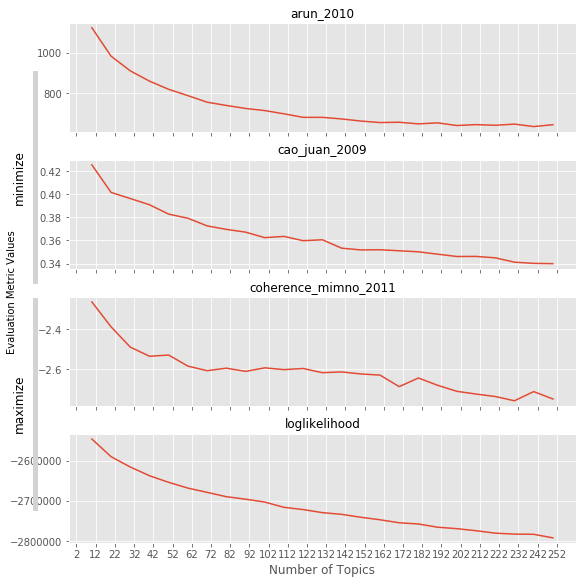

In [292]:
#%matplotlib qt
%matplotlib inline

from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.evaluate import results_by_parameter
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

model_name = 'topicmodel1'
#model_name = 'topicmodel2'
models = topic_models_dict[model_name]

results_by_n_topics = results_by_parameter(models, 'n_topics')
plot_eval_results(results_by_n_topics)
plt.xlabel('Number of Topics')
plt.xticks(np.arange(2, 262, step=10))
fig = plt.gcf()
fig.text(0.01, 0.5, "Evaluation Metric Values", ha="center", va="center", rotation=90)

plt.savefig(model_name + '.pdf')
#plt.savefig(model_name + 'blu.pdf')
plt.show()

In [293]:
from tmtoolkit.topicmod.evaluate import results_by_parameter

n_topics = 90
n_topics = 50


results_by_n_topics = results_by_parameter(models, 'n_topics')
best_model = dict(results_by_n_topics)[n_topics]['model']

In [294]:
%%capture cap --no-stderr
topic_word_dist = best_model.topic_word_.copy()
doc_topic_dist = best_model.doc_topic_.copy()

n_top_words = 30
for i, topic_dist in enumerate(topic_word_dist):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [295]:
with open(model_name + 'with' + str(n_topics) + 'topics' + str(n_top_words) + 'topwords.txt', 'w') as handle:
    handle.write(cap.stdout)

14005

In [296]:
%%capture cap --no-stderr
from tmtoolkit.topicmod.model_stats import get_doc_lengths, get_marginal_topic_distrib

doc_lengths = get_doc_lengths(dtm)
print('document lengths (num. of tokens per doc.): %s' % doc_lengths)

p_t = get_marginal_topic_distrib(best_model.doc_topic_, doc_lengths)
print('marginal topic distribution P(T): %s' % p_t)

In [297]:
with open(model_name + 'with' + str(n_topics) + 'statsdoclenmargin.txt', 'w') as handle:
    handle.write(cap.stdout)

407

In [298]:
%%capture cap --no-stderr

from tmtoolkit.topicmod.model_stats import get_topic_word_relevance
from tmtoolkit.topicmod.model_stats import get_most_relevant_words_for_topic, get_least_relevant_words_for_topic


rel_mat = get_topic_word_relevance(best_model.topic_word_, best_model.doc_topic_, doc_lengths, lambda_=0.6)
#assert rel_mat.shape == (n_topics, vocab_size)


n_rel_words = 20
topic = 1   # topic to choose from 0..n_topics-1
most_relevant = get_most_relevant_words_for_topic(vocab, rel_mat, topic, n_rel_words)
least_relevant = get_least_relevant_words_for_topic(vocab, rel_mat, topic, n_rel_words)

print(str(n_rel_words) + ' most relevant words in topic %d: %s' % (topic, most_relevant))
print(str(n_rel_words) + ' least relevant words in topic %d: %s' % (topic, least_relevant))

In [299]:
with open(model_name + 'with' + str(n_topics) + 'the' + str(n_rel_words) + 'most_rel_words_topic_' + str(topic) + '.txt', 'w') as handle:
    handle.write(cap.stdout)

500

In [300]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

(array([15., 34., 25.,  6.]),
 array([0.008, 0.011, 0.013, 0.015, 0.018]),
 <a list of 4 Patch objects>)

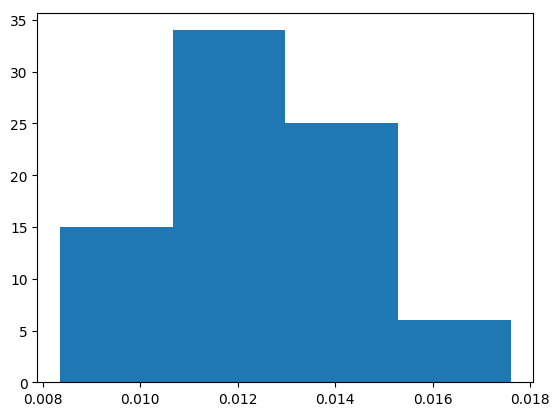

In [301]:
import math
np.set_printoptions(precision=3)

import matplotlib.pyplot as plt
import seaborn as sns

plt.hist([i for i in [0.01134529, 0.01090217, 0.0135556 , 0.01550465, 0.01254789, 0.01295967
, 0.00835119, 0.01410135, 0.01040887, 0.0124433 , 0.01473657, 0.01133981
, 0.0126861 , 0.00971042, 0.01112845, 0.01007792, 0.01166437, 0.01409028
, 0.01302131, 0.01254445, 0.0114274 , 0.00993168, 0.01047816, 0.01146486
, 0.01656842, 0.01342247, 0.0115007 , 0.01346713, 0.0104294 , 0.01432004
, 0.01204021, 0.01432775, 0.01123951, 0.01109929, 0.00897872, 0.01234819
, 0.0101122 , 0.01656604, 0.01232929, 0.01760198, 0.01256466, 0.01248819
, 0.01038443, 0.01096708, 0.01437003, 0.01343124, 0.01183758, 0.01369488
, 0.00974349, 0.01456879, 0.01241837, 0.01532398, 0.0085798 , 0.01117875
, 0.01448549, 0.01414656, 0.01490081, 0.01253973, 0.01449424, 0.01083852
, 0.01121814, 0.0132816 , 0.01397851, 0.01569697, 0.01095566, 0.01386986
, 0.00902962, 0.01448061, 0.0101026 , 0.0104425 , 0.01161516, 0.01288483
, 0.01292884, 0.01486656, 0.01320998, 0.01285872, 0.01323956, 0.01272806
, 0.01468981, 0.01219273]], bins=4)  # arguments are passed to np.histogram

plt.savefig(model_name + 'with' + str(n_topics) + 'topics' + 'cuisine_marginal_topic_distribution_histogram.png')
plt.show()

In [302]:
best_model.doc_topic_

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.112],
       [0.001, 0.001, 0.234, ..., 0.001, 0.001, 0.134],
       [0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       ...,
       [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007],
       [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007],
       [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007]])

In [11]:
#pd.set_option('display.max_colwidth', -1)  # to see all rows in pd dataframe

# t-SNE
### takes around 3.5 min

In [245]:
from MulticoreTSNE import MulticoreTSNE
from sklearn.manifold import TSNE
import scipy

perp_number = 30
doc_topic_dist = best_model.doc_topic_.copy()

tsne = MulticoreTSNE(n_components=2, perplexity=perp_number, random_state=0, n_iter=1000, n_jobs=16)

ing_list2topics_2d = tsne.fit_transform(doc_topic_dist)

In [246]:
tsne_filename = model_name + 'tsne2d_perp' + str(perp_number) + '.joblib.pkl'
joblib.dump(ing_list2topics_2d, tsne_filename)

['topicmodel1tsne2d_perp30.joblib.pkl']

In [247]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

perp_number = 30
tsne_filename = model_name + 'tsne2d_perp' + str(perp_number) + '.joblib.pkl'

tokenlist2cuisine = [inglist[-1][:-7] for inglist in token_list]
cuisine_labels = tokenlist2cuisine

#ing_lists2topics_2d = joblib.load(tsne_filename)
ing_list2topics_2d_df = pd.DataFrame(ing_list2topics_2d).rename(index=str, columns={0: "x_t-SNE", 1: "y_t-SNE"})

cuisine_labels_df = pd.DataFrame(cuisine_labels).rename(index=str, columns={0: "cuisine"})
data_df = pd.concat([ing_list2topics_2d_df, cuisine_labels_df], axis=1)

print(data_df[:2])

    x_t-SNE    y_t-SNE        cuisine
0 -4.445016 -28.200196  NorthAmerican
1  0.220274 -13.757219  NorthAmerican


,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker,cuisine_color,cuisine_marker
0,-4.445016,-28.200196,NorthAmerican,#90EE90,*,#90EE90,*
1,0.220274,-13.757219,NorthAmerican,#90EE90,*,#90EE90,*


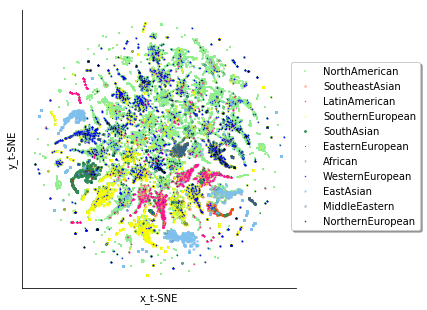

In [249]:
#%matplotlib qt
%matplotlib inline

import seaborn as sns
from matplotlib import rcParams
rcParams.update({'pgf.rcfonts': True})  # False if want to use latex documents fonts
rcParams['figure.autolayout'] = False

# maybe use matplotlib2tikz


palette = OrderedDict([
    ('NorthernEuropean', 'black'),
    ('EasternEuropean', 'darkgreen'),
    ('NorthAmerican','#90EE90'),  ## 'palegreen2'
    ('WesternEuropean', 'blue'),  ### 'dodgerblue2'
    #
    ('EastAsian', '#7ec0ee'), ## 'skyblue2'
    ('SoutheastAsian', '#ff4c00'),  ###'darkorange'
    #
    ('SouthAsian', "seagreen"),
    #
    ('LatinAmerican', '#FF1493'),  ### 'deeppink1'
    ('SouthernEuropean', '#ffff00'),  ### 'yellow4'
    ('MiddleEastern', '#36648b'),  # steelblue4
    ('African', '#8b4500')  ###'darkorange4'
])

markers_odict = OrderedDict([
    ('NorthernEuropean', '|'),
    ('EasternEuropean', '$o$'),
    ('NorthAmerican', '*'),
    ('WesternEuropean', '$z$'),
    ('EastAsian', 'x'),  ###
    ('SoutheastAsian', '.'),
    ('SouthAsian', '$Y$'),  ###
    ('LatinAmerican', '*'),
    ('SouthernEuropean', 'X'),
    ('MiddleEastern', '$o$'),
    ('African', '*'),   ###
])


markers = [marker for marker in markers_odict.values()]

cuisine_colors = pd.DataFrame([palette[cuisine] for cuisine in cuisine_labels]).rename(index=str, columns={0: "cuisine_color"})
cuisine_markers = pd.DataFrame([markers_odict[cuisine] for cuisine in cuisine_labels]).rename(index=str, columns={0: "cuisine_marker"})
data_df = pd.concat([data_df, cuisine_colors, cuisine_markers], axis=1)
data_df[:2]


g = sns.lmplot(x='x_t-SNE',  # Horizontal axis
               y='y_t-SNE',  # Vertical axis
               data=data_df,  # Data source
               fit_reg=False,  # Don't fix a regression line
               legend=False,  # legend to be drawn separately later
               #legend_out=True,
               height=12,
               hue='cuisine',  # color according to column in data_df
               palette=palette,
               #markers='.'
               markers=markers,
               # aspect=2  # size and dimension
               scatter_kws={'s':4, 'alpha':0.9, 'linewidths':0.1}#,'edgecolor':'k'}
               )
ax = g.axes

#fig.suptitle('300-Dimensional im2recipe-fasttext-embedding of categorized ingredients as 2-D t-SNE', weight='bold').set_fontsize('14')
lgd = g.fig.get_axes()[0].legend(loc='right',
           bbox_to_anchor=(1.47, 0.51),
           ncol=1,
           fancybox=True,
           shadow=True)
#g.fig.tight_layout()
#g.fig.subplots_adjust(left=0.5)
#g.fig.tight_layout(rect=[0,0,0.75,2])
g.set(xticks=[])
g.set(yticks=[])
fig = g.fig

#fig_width_cm = 21                         # A4 page
#fig_height_cm = 29.7
fig_width_cm = 21                         # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54              # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig.set_size_inches(fig_width/2, fig_width/2)

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


tsne_plot_filename_pdf = model_name + 'plot_tsne2d_perp' + str(perp_number) + '.pdf'
tsne_plot_filename_pgf = model_name + 'plot_tsne2d_perp' + str(perp_number) + '.pgf'

# save to file
fig.savefig(tsne_plot_filename_pdf, dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))
fig.savefig(tsne_plot_filename_pgf, dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

## More Statistics and Visualizations

In [303]:
%%capture cap --no-stderr
from tmtoolkit.topicmod.model_stats import get_most_distinct_words, get_least_distinct_words

most_distinct = get_most_distinct_words(vocab, best_model.topic_word_, best_model.doc_topic_, doc_lengths, 50)
least_distinct = get_least_distinct_words(vocab, best_model.topic_word_, best_model.doc_topic_, doc_lengths, 50)

print('50 most distinct words: %s' % most_distinct)
print('50 least distinct words: %s' % least_distinct)

In [304]:
with open(model_name + 'with' + str(n_topics) + 'topics_distinctive_words.txt', 'w') as handle:
    handle.write(cap.stdout)

1336

In [305]:
%%capture cap --no-stderr
from tmtoolkit.topicmod.model_stats import get_most_salient_words, get_least_salient_words

most_salient = get_most_salient_words(vocab, best_model.topic_word_, best_model.doc_topic_, doc_lengths, 50)
least_salient = get_least_distinct_words(vocab, best_model.topic_word_, best_model.doc_topic_, doc_lengths, 50)

print('10 most salient words: %s' % most_salient)
print('10 least salient words: %s' % least_salient)

In [306]:
with open(model_name + 'with' + str(n_topics) + 'topics_salient_words.txt', 'w') as handle:
    handle.write(cap.stdout)

1264

In [307]:
%%capture cap --no-stderr
n_docs, n_topics = best_model.doc_topic_.shape
vocab_size = len(vocab)

print('model with %d topics learnt from %d documents with vocabulary size of %d unique words'
      % (n_topics, n_docs, vocab_size))

In [308]:
with open(model_name + 'with' + str(n_topics) + 'statsvocsize.txt', 'w') as handle:
    handle.write(cap.stdout)

90

In [309]:
bestmodeltopicword = best_model.topic_word_.copy()
vocabcopy = vocab.copy()
bestdoctopic = best_model.doc_topic_.copy()

In [310]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words
img_w = 400   # image width
img_h = 300   # image height

topn = 20
topic_clouds = generate_wordclouds_for_topic_words(bestmodeltopicword,
                                                   vocabcopy,
                                                   top_n=topn,
                                                   width=img_w,
                                                   height=img_h)
#topic_clouds.keys()

In [311]:
from tmtoolkit.topicmod import visualize
#for i in range(1, 90):
#    print(i)
#    topic_clouds['topic_' + str(i)]

#topic_clouds['topic_2']
#topic_clouds['topic_45']


import os

output_dir = './' + model_name + 'wordclouds' + str(topn)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

visualize.write_wordclouds_to_folder(topic_clouds, output_dir)
print('files were saved to directory: %s' % output_dir)

files were saved to directory: ./topicmodel1wordclouds20


In [312]:
abbrev_tokenlist2cuisine_df = pd.DataFrame([' '.join(inglist[:5]) for inglist in token_list]).rename(index=str, columns={0: "tokenabbrev"})
data_df_tokenabbrev = pd.concat([data_df, abbrev_tokenlist2cuisine_df], axis=1)
data_df_tokenabbrev[:3]

,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker,cuisine_color,cuisine_marker,tokenabbrev
0,-4.445016,-28.200196,NorthAmerican,#90EE90,*,#90EE90,*,olive_oil pepper mushroom black_pepper lettuce
1,0.220274,-13.757219,NorthAmerican,#90EE90,*,#90EE90,*,butter green_bell_pepper celery_oil shallot corn
2,2.670647,-11.476322,NorthAmerican,#90EE90,*,#90EE90,*,olive_oil pepper lemon_juice mustard corn_grit


In [313]:
data_df_southerneuropean = data_df_tokenabbrev.loc[data_df_tokenabbrev['cuisine'] == 'SouthernEuropean']
data_df_eastasian = data_df_tokenabbrev.loc[data_df_tokenabbrev['cuisine'] == 'EastAsian']

data_df_eastasian[:5]
data_df_eastasian['tokenabbrev'].tolist()[:5]
data_df_southerneuropean['tokenabbrev'].tolist()[:5]

,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker,cuisine_color,cuisine_marker,tokenabbrev
55,-12.054697,-18.577293,EastAsian,#7ec0ee,x,#7ec0ee,x,cane_molasses cheese pork wheat celery_oil
61,24.302467,-16.315013,EastAsian,#7ec0ee,x,#7ec0ee,x,fenugreek pepper mushroom starch ginger
105,14.028107,-34.220673,EastAsian,#7ec0ee,x,#7ec0ee,x,pork sesame_oil starch matsutake black_pepper
108,35.600855,-27.517803,EastAsian,#7ec0ee,x,#7ec0ee,x,pork sesame_oil mushroom starch black_pepper
142,27.802204,-16.676445,EastAsian,#7ec0ee,x,#7ec0ee,x,cane_molasses pepper sesame_oil starch ginger


['cane_molasses cheese pork wheat celery_oil',
 'fenugreek pepper mushroom starch ginger',
 'pork sesame_oil starch matsutake black_pepper',
 'pork sesame_oil mushroom starch black_pepper',
 'cane_molasses pepper sesame_oil starch ginger']

['olive_oil pork fish fennel lobster',
 'olive_oil pepper brussels_sprout fenugreek nut',
 'olive_oil green_bell_pepper cream_cheese mushroom black_pepper',
 'olive_oil lemon_juice wheat shallot black_pepper',
 'coriander pepper fenugreek tabasco_pepper black_pepper']

In [314]:
from tmtoolkit.topicmod import visualize
#doc_clouds = visualize.generate_wordclouds_for_document_topics(best_model.doc_topic_,                                             
#                                                               data_df_tokenabbrev['tokenabbrev'].tolist(),
#                                                               top_n=5,
#                                                               which_documents='olive_oil cheese black_pepper garlic',
#                                                               width=img_w,
#                                                               height=img_h)
#doc_clouds.keys()

In [315]:
import os

output_dir = './wordclouds_doctopic'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

visualize.write_wordclouds_to_folder(topic_clouds, output_dir)
print('files were saved to directory: %s' % output_dir)

files were saved to directory: ./wordclouds_doctopic


In [316]:
data_df_southerneuropean = data_df_tokenabbrev.loc[data_df_tokenabbrev['cuisine'] == 'SouthernEuropean']
data_df_eastasian = data_df_tokenabbrev.loc[data_df_tokenabbrev['cuisine'] == 'EastAsian']

data_df_eastasian[:5]
data_df_eastasian['tokenabbrev'].tolist()[:5]

,x_t-SNE,y_t-SNE,cuisine,cuisine_color,cuisine_marker,cuisine_color,cuisine_marker,tokenabbrev
55,-12.054697,-18.577293,EastAsian,#7ec0ee,x,#7ec0ee,x,cane_molasses cheese pork wheat celery_oil
61,24.302467,-16.315013,EastAsian,#7ec0ee,x,#7ec0ee,x,fenugreek pepper mushroom starch ginger
105,14.028107,-34.220673,EastAsian,#7ec0ee,x,#7ec0ee,x,pork sesame_oil starch matsutake black_pepper
108,35.600855,-27.517803,EastAsian,#7ec0ee,x,#7ec0ee,x,pork sesame_oil mushroom starch black_pepper
142,27.802204,-16.676445,EastAsian,#7ec0ee,x,#7ec0ee,x,cane_molasses pepper sesame_oil starch ginger


['cane_molasses cheese pork wheat celery_oil',
 'fenugreek pepper mushroom starch ginger',
 'pork sesame_oil starch matsutake black_pepper',
 'pork sesame_oil mushroom starch black_pepper',
 'cane_molasses pepper sesame_oil starch ginger']

In [317]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

[15589, 1993, 483, 977, 27364, 8252, 6655, 28135, 50822, 43949, 22047]


(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c4c84a780>)

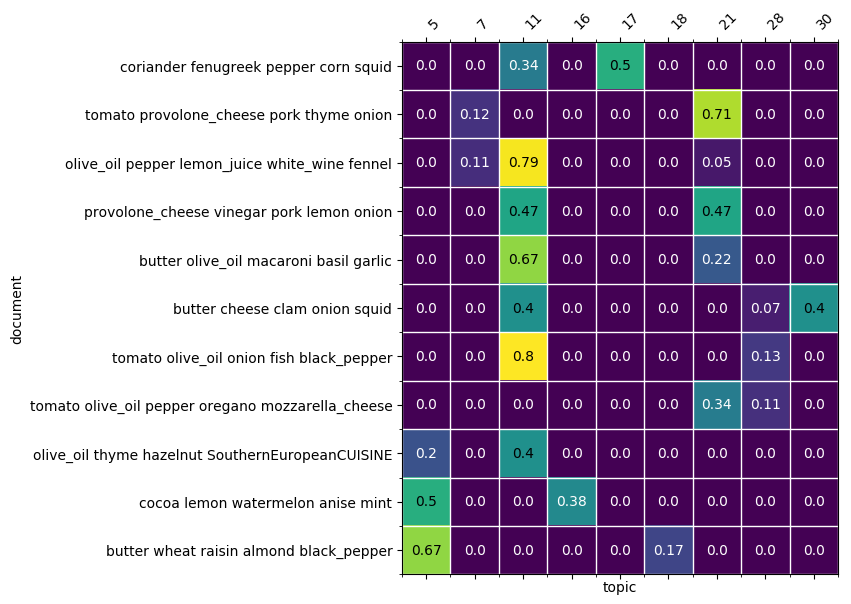

In [397]:
doclabels1 = data_df_tokenabbrev['tokenabbrev'].tolist()

selecteddocs1 = data_df_southerneuropean.sample(20)
selecteddocs1_ids = [int(x) for x in selecteddocs1.index.tolist()]
selecteddocs1_ids = [15589, 1993, 483, 977, 27364, 8252, 6655, 28135, 50822, 43949, 22047]
print(selecteddocs1_ids)

topic_indices = [x-1 for x in [5, 7, 11, 16, 17, 18, 21, 28, 30]]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))  # create a figure to draw on

visualize.plot_doc_topic_heatmap(fig=fig, 
                                 ax=ax, 
                                 doc_topic_distrib = best_model.doc_topic_, 
                                 doc_labels=doclabels1,
                                 which_document_indices=selecteddocs1_ids,  # select the documents
                                 which_topic_indices=topic_indices)

plt.tight_layout()
plt.show();


fig.savefig(model_name + 'heatmapsoutherneuropean.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

[14037, 42624, 11775, 48253, 51039, 49420, 4612, 20646, 33757, 46832, 49012]


(<Figure size 800x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5c4c8d6240>)

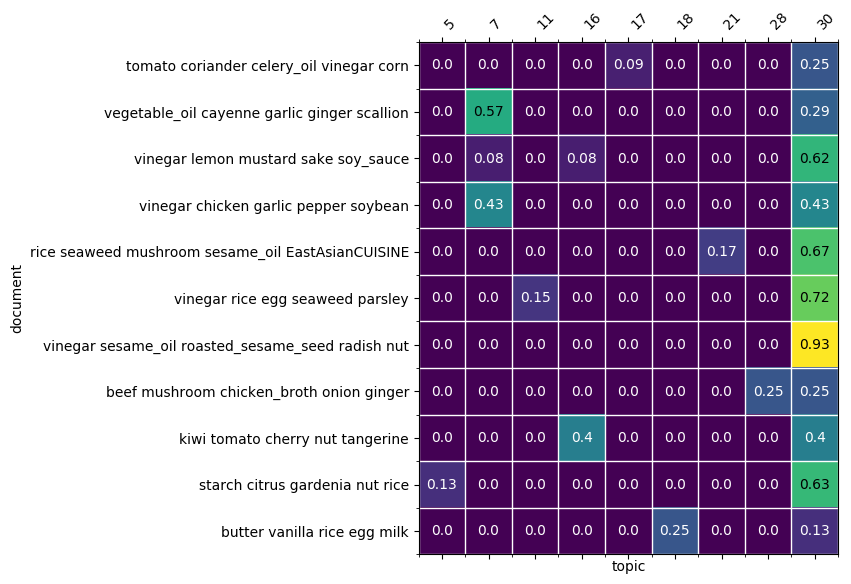

In [398]:
doclabels2 = data_df_tokenabbrev['tokenabbrev'].tolist()

selecteddocs2 = data_df_eastasian.sample(25)
selecteddocs2_ids = [int(x) for x in selecteddocs2.index.tolist()]
selecteddocs2_ids = [14037, 42624, 11775, 48253, 51039, 49420, 4612, 20646, 33757, 46832, 49012]
print(selecteddocs2_ids)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))  # create a figure to draw on

visualize.plot_doc_topic_heatmap(fig=fig, 
                                 ax=ax, 
                                 doc_topic_distrib = best_model.doc_topic_, 
                                 doc_labels=doclabels2,
                                 which_document_indices=selecteddocs2_ids,  # select the documents
                                 which_topic_indices=topic_indices)

plt.tight_layout()
plt.show();
fig.savefig(model_name + 'heatmapeastasian.pdf', dpi=72, bbox_inches='tight', bbox_extra_artists=(lgd,))

## pyLDAvis

In [399]:
import pyLDAvis
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, print_ldamodel_doc_topics

pyLDAvis.enable_notebook()

vis_data = pyLDAvis.prepare(topic_term_dists=best_model.topic_word_,
                            doc_topic_dists=best_model.doc_topic_,
                            doc_lengths=doc_lengths,
                            vocab=vocab,
                            term_frequency=counts_array)
pyLDAvis.save_html(vis_data, model_name + 'with' + str(n_topics) + 'pyLDAvis.html')

/media/zeug/CODE/im2recipe-Pytorch/env3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [400]:
import pyLDAvis
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, print_ldamodel_doc_topics

pyLDAvis.enable_notebook()

pyLDAvis.prepare(topic_term_dists=best_model.topic_word_,
                            doc_topic_dists=best_model.doc_topic_,
                            doc_lengths=doc_lengths,
                            vocab=vocab,
                            term_frequency=counts_array)
#pyLDAvis.save_html(vis_data, model_name + 'with' + str(n_topics) + 'pyLDAvis.html')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
36    -0.167972  0.037836       1        1  2.755216
18    -0.178043  0.184401       2        1  2.573535
20    -0.231522 -0.166897       3        1  2.452684
1      0.328030 -0.028635       4        1  2.380501
16    -0.179798  0.118020       5        1  2.368459
5      0.289564  0.089567       6        1  2.351508
47    -0.261886 -0.021339       7        1  2.334915
35     0.298893  0.034522       8        1  2.270049
48    -0.263139 -0.109373       9        1  2.257446
32    -0.152435  0.182250      10        1  2.255356
41    -0.214155 -0.123265      11        1  2.248032
2     -0.156034 -0.091573      12        1  2.177498
13     0.306872 -0.048358      13        1  2.173935
42     0.307387  0.062206      14        1  2.168490
24    -0.178351 -0.160835      15        1  2.168015
17     0.317385 -0.047120      16        1  2.125659
46    -0.243442 -0.015444      17        1  2.107060
26     0.318253 -0.045136      18        1  2.104384
39     0.304816  0.020312      19        1  2.101449
7     -0.186877 -0.063459      20        1  2.072819
10    -0.238654 -0.058335      21        1  2.060294
31     0.289371 -0.003240      22        1  2.059421
30    -0.029842 -0.137236      23        1  2.056210
11    -0.275460 -0.007770      24        1  2.044647
14    -0.098665 -0.005299      25        1  2.030669
9     -0.075071  0.019720      26        1  2.025380
43     0.293913  0.000018      27        1  2.004393
37    -0.008708 -0.155127      28        1  1.995804
0     -0.102957 -0.141081      29        1  1.972436
4      0.282776  0.021580      30        1  1.952551
38    -0.151525  0.142712      31        1  1.945912
34     0.122713 -0.195073      32        1  1.937711
44    -0.089401 -0.106083      33        1  1.892827
33     0.285412  0.055869      34        1  1.874951
12     0.005547 -0.120837      35        1  1.873842
27    -0.203993  0.079643      36        1  1.816423
40    -0.200360 -0.052908      37        1  1.809020
25    -0.026714 -0.020737      38        1  1.792358
3     -0.243139  0.131878      39        1  1.763485
22     0.179258 -0.054372      40        1  1.742588
23     0.030294 -0.148770      41        1  1.692497
28     0.254673 -0.108314      42        1  1.667329
49    -0.104056 -0.050546      43        1  1.663464
19    -0.137737  0.038307      44        1  1.624402
21     0.000715  0.128883      45        1  1.599456
29    -0.140153  0.253343      46        1  1.582320
8      0.257463 -0.014675      47        1  1.556179
15     0.123612  0.259237      48        1  1.518725
6     -0.217961  0.216961      49        1  1.517643
45     0.161106  0.224573      50        1  1.480052, topic_info=     Category          Freq                     Term         Total  loglift  \
term                                                                          
270   Default  20478.000000                    wheat  20478.000000  30.0000   
132   Default  20689.000000                      egg  20689.000000  29.0000   
35    Default  12687.000000                     milk  12687.000000  28.0000   
235   Default   8800.000000                  vanilla   8800.000000  27.0000   
46    Default  20484.000000                   butter  20484.000000  26.0000   
41    Default   9866.000000                olive_oil   9866.000000  25.0000   
134   Default   7742.000000                  vinegar   7742.000000  24.0000   
205   Default  41219.000000     NorthAmericanCUISINE  41219.000000  23.0000   
344   Default   9916.000000                   tomato   9916.000000  22.0000   
16    Default  16926.000000                   garlic  16926.000000  21.0000   
274   Default   8005.000000                  cayenne   8005.000000  20.0000   
68    Default  18111.000000                    onion  18111.000000  19.0000   
133   Default   7561.000000            cane_molasses   7561.000000  18.0000   
336   Default   